<a href="https://colab.research.google.com/github/knc6/jarvis-tools-notebooks/blob/master/jarvis-tools-notebooks/ALIGNN_Structure_Relaxation_Phonons_Interface.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Examples how to use ALIGNN-FF (https://doi.org/10.1039/D2DD00096B) Pre-trained model.

An example of training ALIGNN-FF from scratch for 307K dataset is given [here](https://github.com/knc6/jarvis-tools-notebooks/blob/master/jarvis-tools-notebooks/Train_ALIGNNFF_JARVIS_DFT_DB_307k.ipynb)

In [1]:
!pip install -q condacolab
import condacolab
condacolab.install()

⏬ Downloading https://github.com/conda-forge/miniforge/releases/download/23.11.0-0/Mambaforge-23.11.0-0-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:17
🔁 Restarting kernel...


Installation with conda

In [1]:
%%time

!conda install dgl=2.1.0 pytorch torchvision torchaudio pytorch-cuda phonopy -c pytorch -c nvidia --quiet

Channels:
 - pytorch
 - nvidia
 - conda-forge
Platform: linux-64
Solving environment: ...working... done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - dgl=2.1.0
    - phonopy
    - pytorch
    - pytorch-cuda
    - torchaudio
    - torchvision


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    _openmp_mutex-4.5          |       2_kmp_llvm           6 KB  conda-forge
    absl-py-2.1.0              |     pyhd8ed1ab_0         105 KB  conda-forge
    annotated-types-0.7.0      |     pyhd8ed1ab_0          18 KB  conda-forge
    astunparse-1.6.3           |     pyhd8ed1ab_2          18 KB  conda-forge
    brotli-1.1.0               |       hd590300_1          19 KB  conda-forge
    brotli-bin-1.1.0           |       hd590300_1          19 KB  conda-forge
    c-ares-1.34.3              |       hb9d3cd8_1         200 KB  conda-forge
    ca-certificates-202

In [1]:
!pip uninstall alignn -y
!pip install -q -U git+https://github.com/usnistgov/alignn.git@develop

Found existing installation: alignn 2024.10.30
Uninstalling alignn-2024.10.30:
  Successfully uninstalled alignn-2024.10.30
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


Import necessary libraries

In [2]:
from jarvis.io.vasp.inputs import Poscar
from alignn.ff.ff import (
    phonons,
    AlignnAtomwiseCalculator,
    default_path,
)
from jarvis.db.figshare import get_jid_data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from jarvis.core.atoms import Atoms, get_supercell_dims
from tqdm import tqdm
from ase.constraints import ExpCellFilter
from sklearn.metrics import mean_absolute_error
import time
from jarvis.core.atoms import ase_to_atoms
from ase.optimize.fire import FIRE
from ase.md.nvtberendsen import NVTBerendsen
from ase.md.velocitydistribution import MaxwellBoltzmannDistribution
from ase import units
from ase.md.nvtberendsen import NVTBerendsen
from ase.md.velocitydistribution import MaxwellBoltzmannDistribution



/usr/local/lib/python3.10/site-packages/torchdata/datapipes/__init__.py:18: UserWarning: 
################################################################################
WARNING!
The 'datapipes', 'dataloader2' modules are deprecated and will be removed in a
future torchdata release! Please see https://github.com/pytorch/data/issues/1196
to learn more and leave feedback.
################################################################################

  deprecation_warning()


A few examples of metals, semiconductors and insulators

In [3]:
jids_check = [
    "JVASP-1002", # Si
    "JVASP-816", # Al
    "JVASP-867", # Cu
    "JVASP-1029", # Ti
    "JVASP-861", # Cr
    "JVASP-30", # GaN Pg3mmc
    "JVASP-8169", #GaN F-43m
    "JVASP-890", #Ge
    "JVASP-8158", #SiC F-43m
    "JVASP-8118", #SiC P6_3mmc
    "JVASP-107", #SiC P6_3mc
    "JVASP-39", #AlN P6_3mc
    "JVASP-7844", #AlN F-43m
    "JVASP-35106", #Al3GaN4 P-43m
    "JVASP-1174", #GaAs F-43m
    "JVASP-1372", #AlAs F-43m
    "JVASP-91", #C Fd-3m
    "JVASP-1186", #InAs F-43M
    "JVASP-1408", #AlSb F-43M
    "JVASP-105410", #SiGe F-43m
    "JVASP-1177", #GaSb F-43m
    "JVASP-79204", #BN P63mc
    "JVASP-1393", #GaP F-43m
    "JVASP-1312", #BP F-43m
    "JVASP-1327", #AlP F-43m
    "JVASP-1183", #InP F-43m
    "JVASP-1192", #CdSe F-43m
    "JVASP-8003", #CdS F-43m
    "JVASP-96", #ZnSe F-43m
    "JVASP-1198", #ZnTe F-43m
    "JVASP-1195", #ZnO P63mc
    "JVASP-9147", #HfO2 P21c
    "JVASP-41", #SiO2 P3_221
    "JVASP-34674", #SiO2 C222_1
    "JVASP-113", #ZrO2 P2_1c
    "JVASP-32", #Al2O3 R-3c
]


In [4]:
def general_relaxer(atoms="", calculator="", fmax=0.05, steps=150):
    ase_atoms = atoms.ase_converter()
    ase_atoms.calc = calculator
    ase_atoms = ExpCellFilter(ase_atoms)

    dyn = FIRE(ase_atoms)
    dyn.run(fmax=fmax, steps=steps)
    return ase_to_atoms(ase_atoms.atoms)


dir_path /usr/local/lib/python3.10/site-packages/alignn/ff/v12.2.2024_dft_3d_307k
model_path /usr/local/lib/python3.10/site-packages/alignn/ff/v12.2.2024_dft_3d_307k


  0%|          | 0/36 [00:00<?, ?it/s]

Obtaining 3D dataset 76k ...
Reference:https://www.nature.com/articles/s41524-020-00440-1
Other versions:https://doi.org/10.6084/m9.figshare.6815699
Loading the zipfile...
Loading completed.
System
1.0
3.3641499856336465 -2.5027128e-09 1.94229273881412
1.121382991333525 3.1717517190189715 1.9422927388141193
-2.5909987e-09 -1.8321133e-09 3.884586486670313
Si 
2 
direct
0.8750000000000001 0.875 0.875 Si
0.12499999999999999 0.125 0.12500000000000003 Si



<ipython-input-4-63bca42fdf9c>:4: FutureWarning: Import ExpCellFilter from ase.filters
  ase_atoms = ExpCellFilter(ase_atoms)


      Step     Time          Energy          fmax
FIRE:    0 07:12:05       -7.962614        0.014438
0.5193357467651367 System
1.0
3.3641499856336465 -2.5027128e-09 1.94229273881412
1.121382991333525 3.1717517190189715 1.9422927388141193
-2.5909987e-09 -1.8321133e-09 3.884586486670313
Si 
2 
direct
0.8750000000000001 0.875 0.875 Si
0.12499999999999999 0.125 0.12500000000000003 Si



/usr/local/lib/python3.10/site-packages/spglib/spglib.py:115: DeprecationWarning: dict interface (SpglibDataset['number']) is deprecated.Use attribute interface ({self.__class__.__name__}.{key}) instead
  warnings.warn(
/usr/local/lib/python3.10/site-packages/spglib/spglib.py:115: DeprecationWarning: dict interface (SpglibDataset['international']) is deprecated.Use attribute interface ({self.__class__.__name__}.{key}) instead
  warnings.warn(


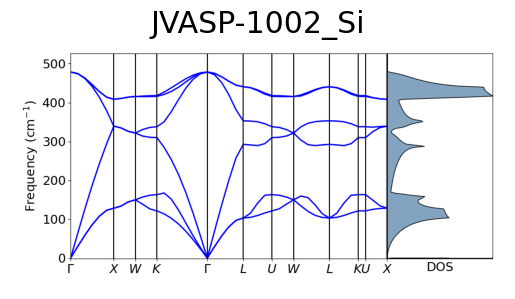

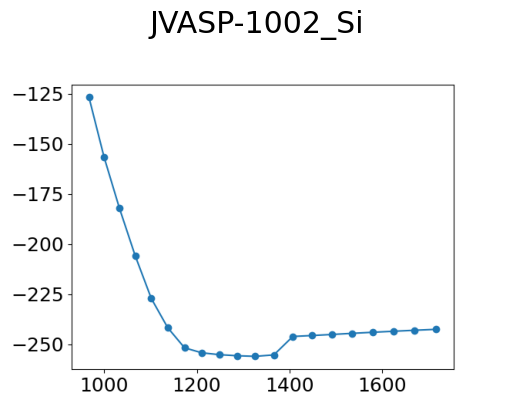

  3%|▎         | 1/36 [00:35<20:51, 35.76s/it]

Obtaining 3D dataset 76k ...
Reference:https://www.nature.com/articles/s41524-020-00440-1
Other versions:https://doi.org/10.6084/m9.figshare.6815699
Loading the zipfile...
Loading completed.
System
1.0
2.4907700981617955 -1.4394159e-09 1.4380466239515413
0.8302566980301707 2.348320626706396 1.438046623951541
-4.0712845e-09 -2.878833e-09 2.8760942620064256
Al 
1 
direct
0.0 0.0 0.0 Al



<ipython-input-4-63bca42fdf9c>:4: FutureWarning: Import ExpCellFilter from ase.filters
  ase_atoms = ExpCellFilter(ase_atoms)


      Step     Time          Energy          fmax
FIRE:    0 07:12:40       -2.168504        0.011865
0.766676664352417 System
1.0
2.4907700981617955 -1.4394159e-09 1.4380466239515413
0.8302566980301707 2.348320626706396 1.438046623951541
-4.0712845e-09 -2.878833e-09 2.8760942620064256
Al 
1 
direct
0.0 0.0 0.0 Al



/usr/local/lib/python3.10/site-packages/spglib/spglib.py:115: DeprecationWarning: dict interface (SpglibDataset['number']) is deprecated.Use attribute interface ({self.__class__.__name__}.{key}) instead
  warnings.warn(
/usr/local/lib/python3.10/site-packages/spglib/spglib.py:115: DeprecationWarning: dict interface (SpglibDataset['international']) is deprecated.Use attribute interface ({self.__class__.__name__}.{key}) instead
  warnings.warn(


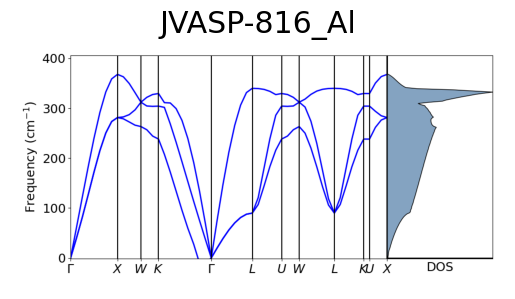

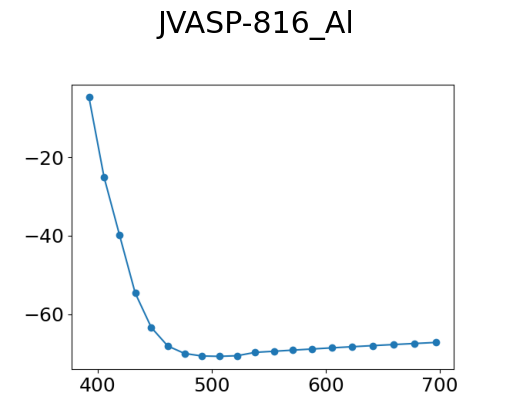

  6%|▌         | 2/36 [01:00<16:29, 29.11s/it]

Obtaining 3D dataset 76k ...
Reference:https://www.nature.com/articles/s41524-020-00440-1
Other versions:https://doi.org/10.6084/m9.figshare.6815699
Loading the zipfile...
Loading completed.
System
1.0
2.2205949027259653 1.4669143979e-05 1.2820850374222705
0.740212133284025 2.0935923255861053 1.2820850376806925
2.07539079666e-05 1.46719687591e-05 2.5641341382616565
Cu 
1 
direct
-1.1134479999999999e-10 2.563159999999999e-11 -4.874599999999991e-12 Cu



<ipython-input-4-63bca42fdf9c>:4: FutureWarning: Import ExpCellFilter from ase.filters
  ase_atoms = ExpCellFilter(ase_atoms)


      Step     Time          Energy          fmax
FIRE:    0 07:13:04        0.651973        0.040019
0.5838847160339355 System
1.0
2.2205949027259653 1.4669143979e-05 1.2820850374222705
0.740212133284025 2.0935923255861053 1.2820850376806925
2.07539079666e-05 1.46719687591e-05 2.5641341382616565
Cu 
1 
direct
-1.1134479999999999e-10 2.563159999999999e-11 -4.874599999999991e-12 Cu



/usr/local/lib/python3.10/site-packages/spglib/spglib.py:115: DeprecationWarning: dict interface (SpglibDataset['number']) is deprecated.Use attribute interface ({self.__class__.__name__}.{key}) instead
  warnings.warn(
/usr/local/lib/python3.10/site-packages/spglib/spglib.py:115: DeprecationWarning: dict interface (SpglibDataset['international']) is deprecated.Use attribute interface ({self.__class__.__name__}.{key}) instead
  warnings.warn(


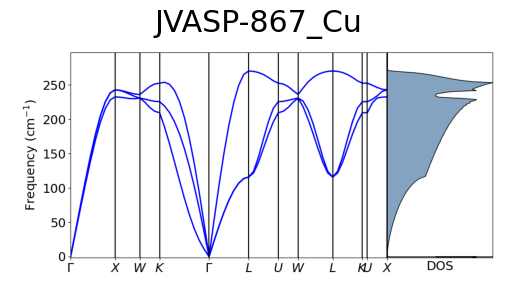

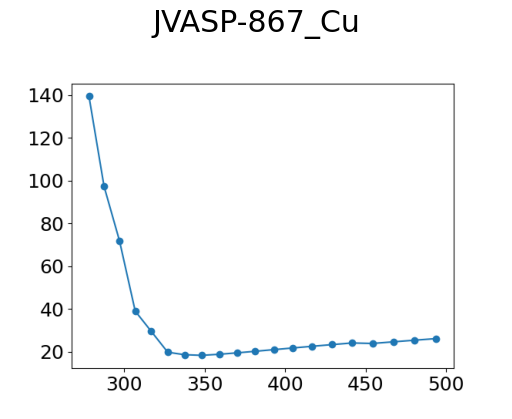

  8%|▊         | 3/36 [01:24<14:50, 26.99s/it]

Obtaining 3D dataset 76k ...
Reference:https://www.nature.com/articles/s41524-020-00440-1
Other versions:https://doi.org/10.6084/m9.figshare.6815699
Loading the zipfile...
Loading completed.
System
1.0
2.273420132082977 -3.9376803190778005 0.0
2.2734201320829777 3.9376803190778005 0.0
0.0 0.0 2.820165120472419
Ti 
3 
direct
0.0 0.0 0.0 Ti
0.3333330000000032 0.6666669999999968 0.49999999999999994 Ti
0.6666669999999968 0.3333330000000032 0.49999999999999994 Ti



<ipython-input-4-63bca42fdf9c>:4: FutureWarning: Import ExpCellFilter from ase.filters
  ase_atoms = ExpCellFilter(ase_atoms)


      Step     Time          Energy          fmax
FIRE:    0 07:13:30      -15.398121        0.284124
FIRE:    1 07:13:30      -15.443141        0.279309
FIRE:    2 07:13:31      -15.531006        0.271324
FIRE:    3 07:13:32      -15.658689        0.261939
FIRE:    4 07:13:32      -15.822822        0.249572
FIRE:    5 07:13:33      -16.015221        0.224591
FIRE:    6 07:13:34      -16.209818        0.181975
FIRE:    7 07:13:35      -16.349792        0.098950
FIRE:    8 07:13:36      -16.351164        0.104722
FIRE:    9 07:13:38      -16.352732        0.101908
FIRE:   10 07:13:38      -16.355675        0.096408
FIRE:   11 07:13:39      -16.359688        0.088462
FIRE:   12 07:13:40      -16.364311        0.078418
FIRE:   13 07:13:40      -16.369072        0.066676
FIRE:   14 07:13:41      -16.373493        0.053689
FIRE:   15 07:13:42      -16.377190        0.039928
12.606149673461914 System
1.0
2.078579625784005 -3.600205967904813 -6.593779207253817e-09
2.0785796323581285 3.6002059

/usr/local/lib/python3.10/site-packages/spglib/spglib.py:115: DeprecationWarning: dict interface (SpglibDataset['number']) is deprecated.Use attribute interface ({self.__class__.__name__}.{key}) instead
  warnings.warn(
/usr/local/lib/python3.10/site-packages/spglib/spglib.py:115: DeprecationWarning: dict interface (SpglibDataset['international']) is deprecated.Use attribute interface ({self.__class__.__name__}.{key}) instead
  warnings.warn(


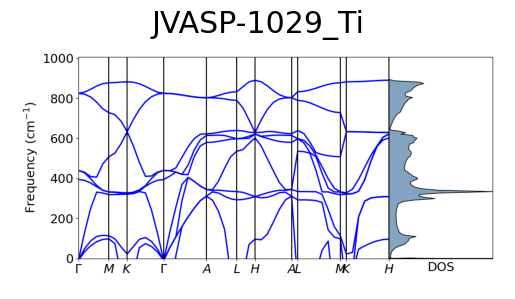

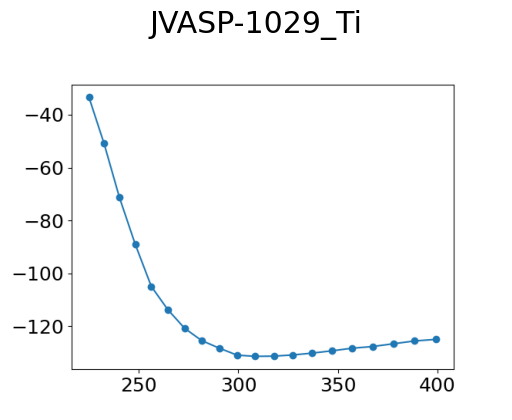

 11%|█         | 4/36 [02:18<20:00, 37.51s/it]

Obtaining 3D dataset 76k ...
Reference:https://www.nature.com/articles/s41524-020-00440-1
Other versions:https://doi.org/10.6084/m9.figshare.6815699
Loading the zipfile...
Loading completed.
System
1.0
2.319094407092078 -9.102157442e-07 -0.8199242029800663
-1.1595485232749354 2.008394485299467 -0.819924296058508
-6.881171935e-07 -1.3067001075e-06 2.4597716564905787
Cr 
1 
direct
1.619573e-10 1.7354659999999999e-10 8.038694e-10 Cr



<ipython-input-4-63bca42fdf9c>:4: FutureWarning: Import ExpCellFilter from ase.filters
  ase_atoms = ExpCellFilter(ase_atoms)


      Step     Time          Energy          fmax
FIRE:    0 07:14:22       -6.368975        0.040472
0.5241270065307617 System
1.0
2.319094407092078 -9.102157442e-07 -0.8199242029800663
-1.1595485232749354 2.008394485299467 -0.819924296058508
-6.881171935e-07 -1.3067001075e-06 2.4597716564905787
Cr 
1 
direct
1.619573e-10 1.7354659999999999e-10 8.038694e-10 Cr



/usr/local/lib/python3.10/site-packages/spglib/spglib.py:115: DeprecationWarning: dict interface (SpglibDataset['number']) is deprecated.Use attribute interface ({self.__class__.__name__}.{key}) instead
  warnings.warn(
/usr/local/lib/python3.10/site-packages/spglib/spglib.py:115: DeprecationWarning: dict interface (SpglibDataset['international']) is deprecated.Use attribute interface ({self.__class__.__name__}.{key}) instead
  warnings.warn(


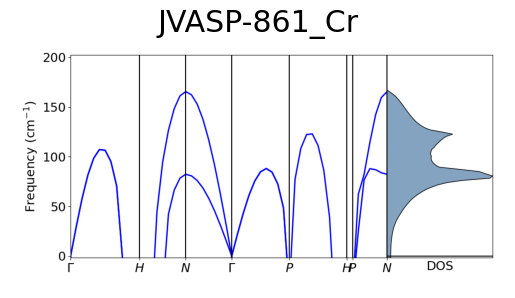

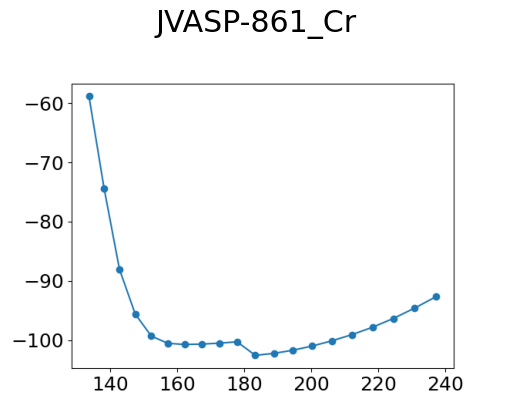

 14%|█▍        | 5/36 [02:42<16:49, 32.56s/it]

Obtaining 3D dataset 76k ...
Reference:https://www.nature.com/articles/s41524-020-00440-1
Other versions:https://doi.org/10.6084/m9.figshare.6815699
Loading the zipfile...
Loading completed.
System
1.0
1.6056404666190551 -2.781051020215259 0.0
1.6056404666190551 2.781051020215259 0.0
0.0 0.0 5.240440132796911
Ga N 
2 2 
direct
0.3333330000000032 0.6666669999999968 0.5005859179897493 Ga
0.6666669999999968 0.3333330000000032 0.0005859179897492 Ga
0.3333330000000032 0.6666669999999968 0.12441408201025081 N
0.6666669999999968 0.3333330000000032 0.6244140820102507 N



<ipython-input-4-63bca42fdf9c>:4: FutureWarning: Import ExpCellFilter from ase.filters
  ase_atoms = ExpCellFilter(ase_atoms)


      Step     Time          Energy          fmax
FIRE:    0 07:14:48      -14.587996        0.126669
FIRE:    1 07:14:48      -14.588119        0.112952
FIRE:    2 07:14:49      -14.588300        0.086901
FIRE:    3 07:14:50      -14.588485        0.051176
FIRE:    4 07:14:51      -14.588605        0.009507
3.8615479469299316 System
1.0
1.6049586843501689 -2.7798700930016547 -2.9851433935257213e-10
1.604958683069695 2.7798700922623736 3.338523639574108e-10
5.766758069535417e-11 5.957963062492845e-10 5.237500375455988
Ga N 
2 2 
direct
0.33333271772878087 0.666666177001339 0.4985433496593683 Ga
0.6666661758905832 0.3333327104433034 -0.0014567042894639273 Ga
0.3333326943159817 0.6666661982831817 0.12645669664858192 N
0.6666661903595658 0.33333269243840585 0.6264567159620422 N



/usr/local/lib/python3.10/site-packages/spglib/spglib.py:115: DeprecationWarning: dict interface (SpglibDataset['number']) is deprecated.Use attribute interface ({self.__class__.__name__}.{key}) instead
  warnings.warn(
/usr/local/lib/python3.10/site-packages/spglib/spglib.py:115: DeprecationWarning: dict interface (SpglibDataset['international']) is deprecated.Use attribute interface ({self.__class__.__name__}.{key}) instead
  warnings.warn(


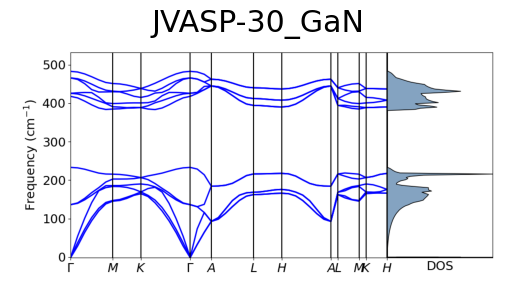

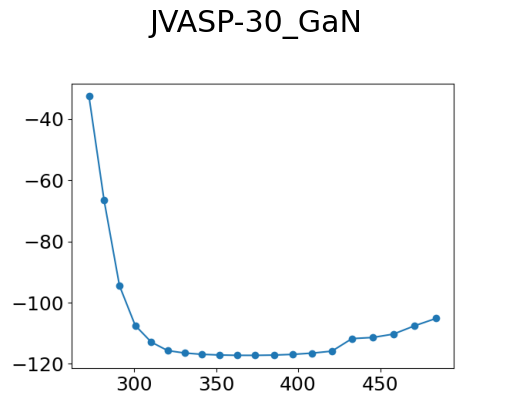

 17%|█▋        | 6/36 [03:39<20:33, 41.12s/it]

Obtaining 3D dataset 76k ...
Reference:https://www.nature.com/articles/s41524-020-00440-1
Other versions:https://doi.org/10.6084/m9.figshare.6815699
Loading the zipfile...
Loading completed.
System
1.0
2.7805059713099647 0.0 1.6053257450263214
0.9268353237699882 2.621486121264764 1.6053257450263214
-0.0 0.0 3.210651490052643
Ga N 
1 1 
direct
0.0 0.0 0.0 Ga
0.25 0.25 0.25 N



<ipython-input-4-63bca42fdf9c>:4: FutureWarning: Import ExpCellFilter from ase.filters
  ase_atoms = ExpCellFilter(ase_atoms)


      Step     Time          Energy          fmax
FIRE:    0 07:15:45       -7.327641        0.004747
0.6450080871582031 System
1.0
2.7805059713099647 0.0 1.6053257450263214
0.9268353237699882 2.621486121264764 1.6053257450263214
-0.0 0.0 3.210651490052643
Ga N 
1 1 
direct
0.0 0.0 0.0 Ga
0.25 0.25 0.25 N



/usr/local/lib/python3.10/site-packages/spglib/spglib.py:115: DeprecationWarning: dict interface (SpglibDataset['number']) is deprecated.Use attribute interface ({self.__class__.__name__}.{key}) instead
  warnings.warn(
/usr/local/lib/python3.10/site-packages/spglib/spglib.py:115: DeprecationWarning: dict interface (SpglibDataset['international']) is deprecated.Use attribute interface ({self.__class__.__name__}.{key}) instead
  warnings.warn(


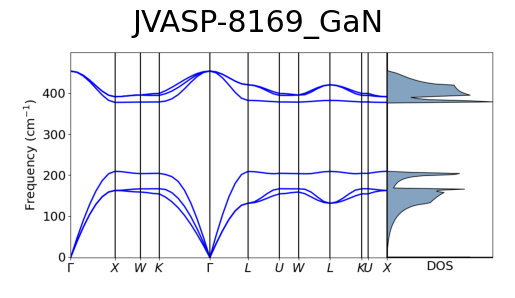

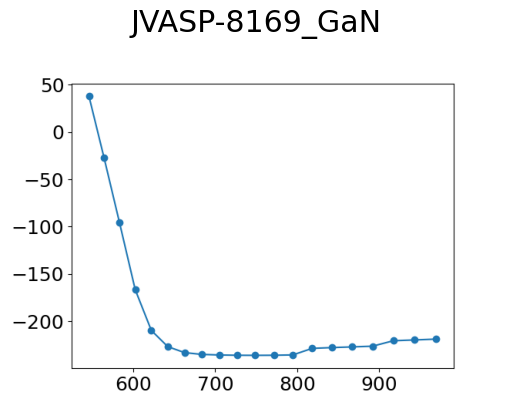

 19%|█▉        | 7/36 [04:23<20:16, 41.94s/it]

Obtaining 3D dataset 76k ...
Reference:https://www.nature.com/articles/s41524-020-00440-1
Other versions:https://doi.org/10.6084/m9.figshare.6815699
Loading the zipfile...
Loading completed.
System
1.0
3.5261943628070638 1.196611e-10 2.035849771621022
1.1753977879818787 3.3245278496612793 2.035849771621022
-4.62335e-10 -3.269202e-10 4.071698544842951
Ge 
2 
direct
0.875 0.875 0.8749999999999999 Ge
0.125 0.125 0.12499999999999999 Ge



<ipython-input-4-63bca42fdf9c>:4: FutureWarning: Import ExpCellFilter from ase.filters
  ase_atoms = ExpCellFilter(ase_atoms)


      Step     Time          Energy          fmax
FIRE:    0 07:16:28       -1.822321        0.048398
0.5898900032043457 System
1.0
3.5261943628070638 1.196611e-10 2.035849771621022
1.1753977879818787 3.3245278496612793 2.035849771621022
-4.62335e-10 -3.269202e-10 4.071698544842951
Ge 
2 
direct
0.875 0.875 0.8749999999999999 Ge
0.125 0.125 0.12499999999999999 Ge



/usr/local/lib/python3.10/site-packages/spglib/spglib.py:115: DeprecationWarning: dict interface (SpglibDataset['number']) is deprecated.Use attribute interface ({self.__class__.__name__}.{key}) instead
  warnings.warn(
/usr/local/lib/python3.10/site-packages/spglib/spglib.py:115: DeprecationWarning: dict interface (SpglibDataset['international']) is deprecated.Use attribute interface ({self.__class__.__name__}.{key}) instead
  warnings.warn(


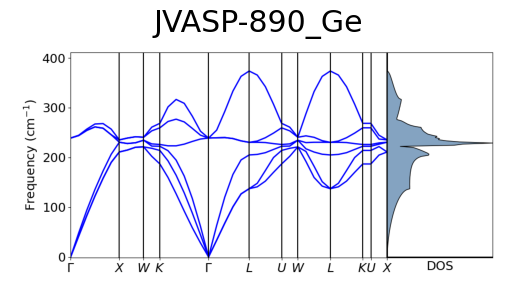

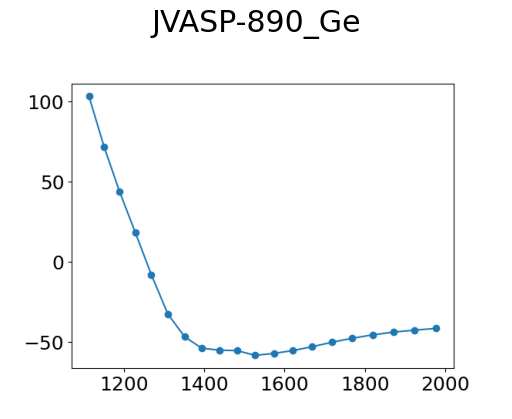

 22%|██▏       | 8/36 [04:56<18:18, 39.24s/it]

Obtaining 3D dataset 76k ...
Reference:https://www.nature.com/articles/s41524-020-00440-1
Other versions:https://doi.org/10.6084/m9.figshare.6815699
Loading the zipfile...
Loading completed.
System
1.0
2.6869744850745265 -3.845503e-10 1.5513250526772773
0.8956581613289514 2.533303526984513 1.5513250526772773
-1.087673e-09 -7.691009e-10 3.1026511091223643
Si C 
1 1 
direct
0.24999999999999997 0.25 0.25 Si
0.0 0.0 0.0 C



<ipython-input-4-63bca42fdf9c>:4: FutureWarning: Import ExpCellFilter from ase.filters
  ase_atoms = ExpCellFilter(ase_atoms)


      Step     Time          Energy          fmax
FIRE:    0 07:17:02      -12.601898        0.029820
0.7243399620056152 System
1.0
2.6869744850745265 -3.845503e-10 1.5513250526772773
0.8956581613289514 2.533303526984513 1.5513250526772773
-1.087673e-09 -7.691009e-10 3.1026511091223643
Si C 
1 1 
direct
0.24999999999999997 0.25 0.25 Si
0.0 0.0 0.0 C



/usr/local/lib/python3.10/site-packages/spglib/spglib.py:115: DeprecationWarning: dict interface (SpglibDataset['number']) is deprecated.Use attribute interface ({self.__class__.__name__}.{key}) instead
  warnings.warn(
/usr/local/lib/python3.10/site-packages/spglib/spglib.py:115: DeprecationWarning: dict interface (SpglibDataset['international']) is deprecated.Use attribute interface ({self.__class__.__name__}.{key}) instead
  warnings.warn(


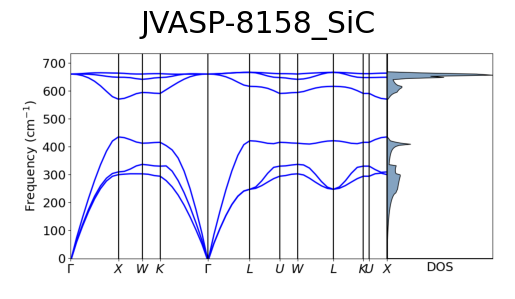

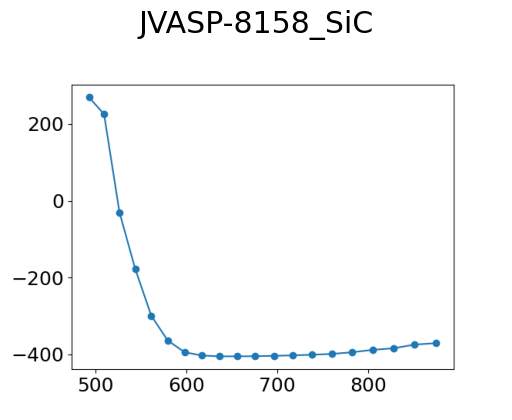

 25%|██▌       | 9/36 [05:40<18:15, 40.59s/it]

Obtaining 3D dataset 76k ...
Reference:https://www.nature.com/articles/s41524-020-00440-1
Other versions:https://doi.org/10.6084/m9.figshare.6815699
Loading the zipfile...
Loading completed.
System
1.0
1.5486099089372707 -2.6822705642693716 -0.0
1.5486099089372707 2.6822705642693716 0.0
0.0 0.0 5.086303822948022
Si C 
2 2 
direct
0.3333330000000032 0.6666669999999967 0.49966399499258707 Si
0.6666669999999968 0.33333300000000315 0.9996639949925871 Si
0.3333330000000032 0.6666669999999967 0.8753360050074128 C
0.6666669999999968 0.33333300000000315 0.3753360050074129 C



<ipython-input-4-63bca42fdf9c>:4: FutureWarning: Import ExpCellFilter from ase.filters
  ase_atoms = ExpCellFilter(ase_atoms)


      Step     Time          Energy          fmax
FIRE:    0 07:17:46      -25.216642        0.054210
FIRE:    1 07:17:46      -25.218359        0.052843
FIRE:    2 07:17:47      -25.221622        0.050144
FIRE:    3 07:17:48      -25.226118        0.046176
3.1923015117645264 System
1.0
1.5436615000230827 -2.673699614023934 5.665640476518472e-10
1.5436614998671114 2.673699613933884 -9.191864825634937e-10
-5.79082191195316e-10 -1.4086905889450785e-09 5.070514206830331
Si C 
2 2 
direct
0.3333337848474753 0.6666672454386408 0.5000363553795534 Si
0.6666672403519575 0.3333337802838044 1.0000366006419799 Si
0.3333337767565482 0.666667252661736 0.8749637575393653 C
0.6666672563711717 0.3333337786482556 0.3749635007017634 C



/usr/local/lib/python3.10/site-packages/spglib/spglib.py:115: DeprecationWarning: dict interface (SpglibDataset['number']) is deprecated.Use attribute interface ({self.__class__.__name__}.{key}) instead
  warnings.warn(
/usr/local/lib/python3.10/site-packages/spglib/spglib.py:115: DeprecationWarning: dict interface (SpglibDataset['international']) is deprecated.Use attribute interface ({self.__class__.__name__}.{key}) instead
  warnings.warn(


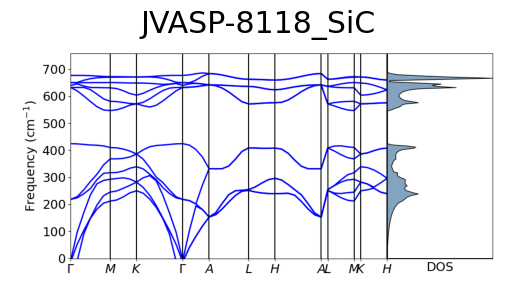

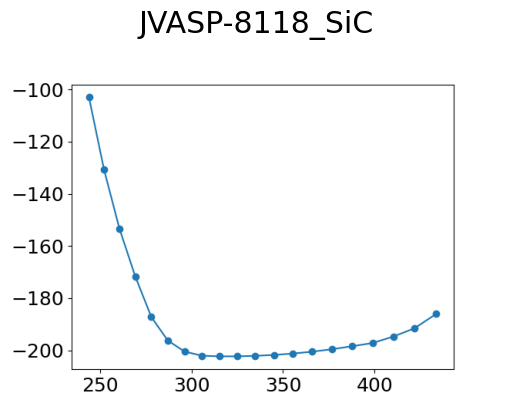

 28%|██▊       | 10/36 [06:37<19:45, 45.59s/it]

Obtaining 3D dataset 76k ...
Reference:https://www.nature.com/articles/s41524-020-00440-1
Other versions:https://doi.org/10.6084/m9.figshare.6815699
Loading the zipfile...
Loading completed.
System
1.0
1.549892767326361 -2.684493224977372 0.0
1.549892767326361 2.684493224977372 0.0
0.0 0.0 10.151391815821647
Si C 
4 4 
direct
0.6666669999999968 0.3333330000000032 0.9378471697430678 Si
0.3333330000000032 0.6666669999999968 0.4378471697430677 Si
0.0 0.0 0.687848348838534 Si
0.0 0.0 0.1878483488385339 Si
0.6666669999999968 0.3333330000000032 0.7498261639014804 C
0.3333330000000032 0.6666669999999968 0.2498261639014804 C
0.0 0.0 0.5004783175169156 C
0.0 0.0 0.0004783175169156 C



<ipython-input-4-63bca42fdf9c>:4: FutureWarning: Import ExpCellFilter from ase.filters
  ase_atoms = ExpCellFilter(ase_atoms)


      Step     Time          Energy          fmax
FIRE:    0 07:18:42      -50.462208        0.115987
FIRE:    1 07:18:43      -50.469967        0.109801
FIRE:    2 07:18:44      -50.483871        0.097848
FIRE:    3 07:18:45      -50.501060        0.080864
FIRE:    4 07:18:47      -50.517956        0.059785
FIRE:    5 07:18:48      -50.530949        0.063952
FIRE:    6 07:18:50      -50.537331        0.064172
FIRE:    7 07:18:51      -50.536522        0.050135
FIRE:    8 07:18:52      -50.536564        0.048473
10.838342905044556 System
1.0
1.511790380530552 -2.618497971639787 3.903779101562025e-09
1.5117903807277355 2.618497971753632 2.8987946399516083e-09
2.227753844069127e-08 -1.9001707554516007e-09 9.91122692025037
Si C 
4 4 
direct
0.6666664889587787 0.3333333468560214 0.9372904401541646 Si
0.333333340709774 0.666666491554241 0.43729056719063325 Si
-6.08041881564977e-07 -7.529872165436952e-07 0.6875785286153661 Si
-7.572168609362193e-07 -6.138173107275747e-07 0.1875786697761082 S

/usr/local/lib/python3.10/site-packages/spglib/spglib.py:115: DeprecationWarning: dict interface (SpglibDataset['number']) is deprecated.Use attribute interface ({self.__class__.__name__}.{key}) instead
  warnings.warn(
/usr/local/lib/python3.10/site-packages/spglib/spglib.py:115: DeprecationWarning: dict interface (SpglibDataset['international']) is deprecated.Use attribute interface ({self.__class__.__name__}.{key}) instead
  warnings.warn(


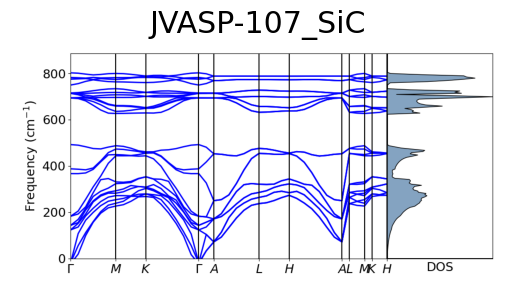

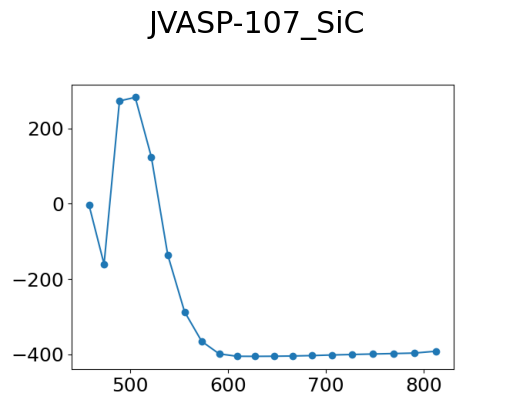

 31%|███       | 11/36 [08:36<28:22, 68.11s/it]

Obtaining 3D dataset 76k ...
Reference:https://www.nature.com/articles/s41524-020-00440-1
Other versions:https://doi.org/10.6084/m9.figshare.6815699
Loading the zipfile...
Loading completed.
System
1.0
1.5650222970111176 -2.7106984478647482 0.0
1.5650222970111176 2.7106984478647482 0.0
0.0 0.0 5.021252677842383
Al N 
2 2 
direct
0.6666669999999968 0.3333330000000032 0.4993312971779396 Al
0.3333330000000032 0.6666669999999968 0.9993312971779398 Al
0.6666669999999968 0.3333330000000032 0.8806687028220628 N
0.3333330000000032 0.6666669999999968 0.380668702822063 N



<ipython-input-4-63bca42fdf9c>:4: FutureWarning: Import ExpCellFilter from ase.filters
  ase_atoms = ExpCellFilter(ase_atoms)


      Step     Time          Energy          fmax
FIRE:    0 07:20:42      -24.318621        0.083994
FIRE:    1 07:20:43      -24.320700        0.077011
FIRE:    2 07:20:44      -24.324781        0.063525
FIRE:    3 07:20:44      -24.330738        0.056272
FIRE:    4 07:20:45      -24.338404        0.053298
FIRE:    5 07:20:46      -24.347586        0.049237
4.486198425292969 System
1.0
1.5513971883174953 -2.687099016854821 6.198925834936561e-10
1.5513971899200583 2.6870990177800644 -1.9340594911034622e-10
6.841746469206907e-10 -7.532703311096761e-10 4.97556074649158
Al N 
2 2 
direct
0.6666650807222058 0.3333316446816824 0.5013315871326537 Al
0.3333316429633915 0.666665088355544 1.0013316415280864 Al
0.6666650940585968 0.3333316225280656 0.8786678297002671 N
0.33333162490817364 0.6666650872096969 0.3786678822236695 N



/usr/local/lib/python3.10/site-packages/spglib/spglib.py:115: DeprecationWarning: dict interface (SpglibDataset['number']) is deprecated.Use attribute interface ({self.__class__.__name__}.{key}) instead
  warnings.warn(
/usr/local/lib/python3.10/site-packages/spglib/spglib.py:115: DeprecationWarning: dict interface (SpglibDataset['international']) is deprecated.Use attribute interface ({self.__class__.__name__}.{key}) instead
  warnings.warn(


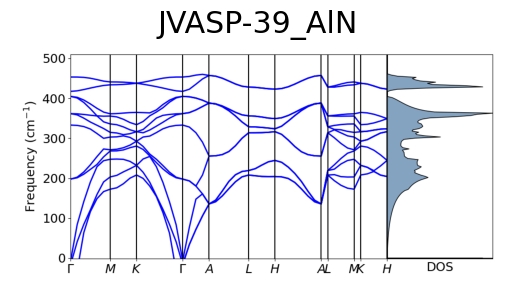

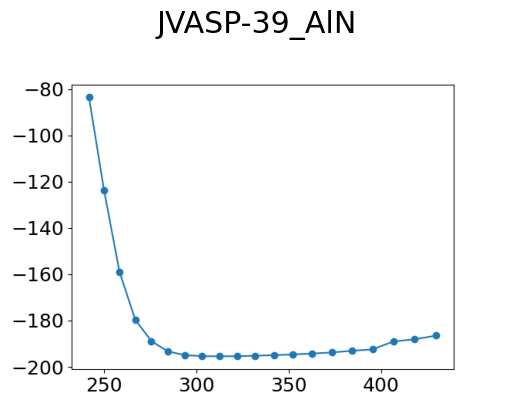

 33%|███▎      | 12/36 [09:35<26:07, 65.32s/it]

Obtaining 3D dataset 76k ...
Reference:https://www.nature.com/articles/s41524-020-00440-1
Other versions:https://doi.org/10.6084/m9.figshare.6815699
Loading the zipfile...
Loading completed.
System
1.0
2.6966971014488705 1.040645e-10 1.5569393383280248
0.8988990339144031 2.5424705153968894 1.5569393383280248
2.943387e-10 2.081289e-10 3.1138776756364304
Al N 
1 1 
direct
0.0 0.0 0.0 Al
0.25 0.25 0.24999999999999997 N



<ipython-input-4-63bca42fdf9c>:4: FutureWarning: Import ExpCellFilter from ase.filters
  ase_atoms = ExpCellFilter(ase_atoms)


      Step     Time          Energy          fmax
FIRE:    0 07:21:40      -12.133336        0.042451
0.7107944488525391 System
1.0
2.6966971014488705 1.040645e-10 1.5569393383280248
0.8988990339144031 2.5424705153968894 1.5569393383280248
2.943387e-10 2.081289e-10 3.1138776756364304
Al N 
1 1 
direct
0.0 0.0 0.0 Al
0.25 0.25 0.24999999999999997 N



/usr/local/lib/python3.10/site-packages/spglib/spglib.py:115: DeprecationWarning: dict interface (SpglibDataset['number']) is deprecated.Use attribute interface ({self.__class__.__name__}.{key}) instead
  warnings.warn(
/usr/local/lib/python3.10/site-packages/spglib/spglib.py:115: DeprecationWarning: dict interface (SpglibDataset['international']) is deprecated.Use attribute interface ({self.__class__.__name__}.{key}) instead
  warnings.warn(


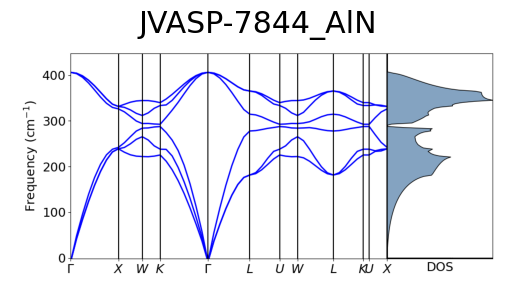

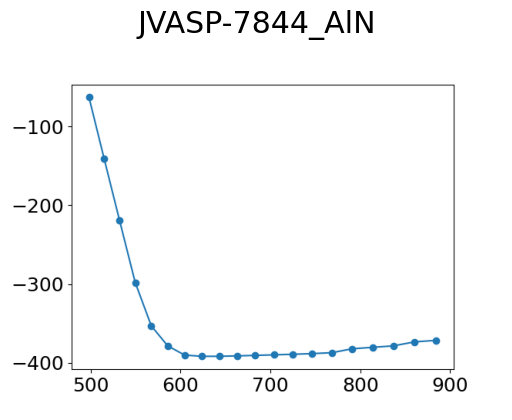

 36%|███▌      | 13/36 [10:20<22:43, 59.27s/it]

Obtaining 3D dataset 76k ...
Reference:https://www.nature.com/articles/s41524-020-00440-1
Other versions:https://doi.org/10.6084/m9.figshare.6815699
Loading the zipfile...
Loading completed.
System
1.0
4.4378970432125495 -0.0 -0.0
-0.0 4.4378970432125495 -0.0
0.0 0.0 4.4378970432125495
Al Ga N 
3 1 4 
direct
0.5 0.5 0.0 Al
0.5 0.0 0.5 Al
0.0 0.5 0.5 Al
0.0 0.0 0.0 Ga
0.7439495711598934 0.7439495711598934 0.2560504288401067 N
0.7439495711598934 0.2560504288401067 0.7439495711598934 N
0.2560504288401067 0.7439495711598934 0.7439495711598934 N
0.2560504288401067 0.2560504288401067 0.2560504288401067 N



<ipython-input-4-63bca42fdf9c>:4: FutureWarning: Import ExpCellFilter from ase.filters
  ase_atoms = ExpCellFilter(ase_atoms)


      Step     Time          Energy          fmax
FIRE:    0 07:22:26      -44.396461        0.165478
FIRE:    1 07:22:27      -44.402721        0.154980
FIRE:    2 07:22:28      -44.414974        0.134569
FIRE:    3 07:22:29      -44.432739        0.105064
FIRE:    4 07:22:31      -44.455593        0.090699
FIRE:    5 07:22:32      -44.483204        0.086106
FIRE:    6 07:22:33      -44.515114        0.079726
FIRE:    7 07:22:34      -44.548523        0.096844
FIRE:    8 07:22:35      -44.549286        0.097282
FIRE:    9 07:22:36      -44.550789        0.098152
FIRE:   10 07:22:37      -44.553028        0.099429
FIRE:   11 07:22:39      -44.555943        0.101078
FIRE:   12 07:22:40      -44.559486        0.103039
FIRE:   13 07:22:42      -44.563591        0.105245
FIRE:   14 07:22:43      -44.568165        0.107581
FIRE:   15 07:22:44      -44.573627        0.110160
FIRE:   16 07:22:45      -44.579983        0.112743
FIRE:   17 07:22:46      -44.587040        0.114811
FIRE:   18 07:

/usr/local/lib/python3.10/site-packages/spglib/spglib.py:115: DeprecationWarning: dict interface (SpglibDataset['number']) is deprecated.Use attribute interface ({self.__class__.__name__}.{key}) instead
  warnings.warn(
/usr/local/lib/python3.10/site-packages/spglib/spglib.py:115: DeprecationWarning: dict interface (SpglibDataset['international']) is deprecated.Use attribute interface ({self.__class__.__name__}.{key}) instead
  warnings.warn(


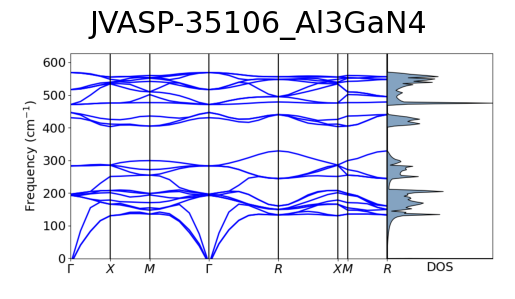

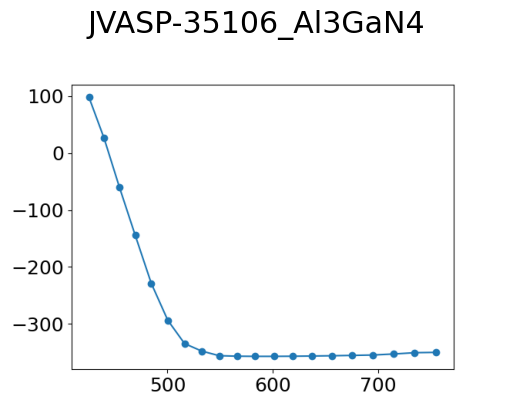

 39%|███▉      | 14/36 [12:35<30:07, 82.15s/it]

Obtaining 3D dataset 76k ...
Reference:https://www.nature.com/articles/s41524-020-00440-1
Other versions:https://doi.org/10.6084/m9.figshare.6815699
Loading the zipfile...
Loading completed.
System
1.0
3.509895098013499 -6.584084e-10 2.026439508259945
1.169965032050413 3.3091606691404545 2.026439508259945
-1.8622597e-09 -1.3168164e-09 4.052878022970947
Ga As 
1 1 
direct
0.0 0.0 0.0 Ga
0.25 0.25 0.24999999999999997 As



<ipython-input-4-63bca42fdf9c>:4: FutureWarning: Import ExpCellFilter from ase.filters
  ase_atoms = ExpCellFilter(ase_atoms)


      Step     Time          Energy          fmax
FIRE:    0 07:24:40       -2.587815        0.042379
0.5908074378967285 System
1.0
3.509895098013499 -6.584084e-10 2.026439508259945
1.169965032050413 3.3091606691404545 2.026439508259945
-1.8622597e-09 -1.3168164e-09 4.052878022970947
Ga As 
1 1 
direct
0.0 0.0 0.0 Ga
0.25 0.25 0.24999999999999997 As



/usr/local/lib/python3.10/site-packages/spglib/spglib.py:115: DeprecationWarning: dict interface (SpglibDataset['number']) is deprecated.Use attribute interface ({self.__class__.__name__}.{key}) instead
  warnings.warn(
/usr/local/lib/python3.10/site-packages/spglib/spglib.py:115: DeprecationWarning: dict interface (SpglibDataset['international']) is deprecated.Use attribute interface ({self.__class__.__name__}.{key}) instead
  warnings.warn(


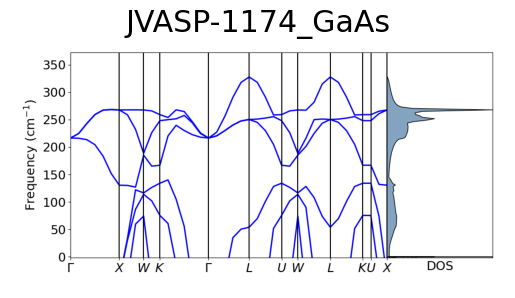

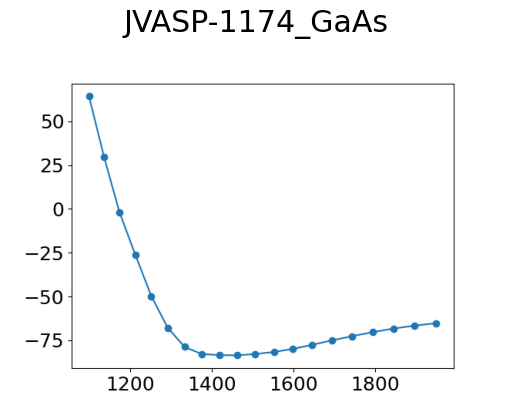

 42%|████▏     | 15/36 [13:08<23:34, 67.38s/it]

Obtaining 3D dataset 76k ...
Reference:https://www.nature.com/articles/s41524-020-00440-1
Other versions:https://doi.org/10.6084/m9.figshare.6815699
Loading the zipfile...
Loading completed.
System
1.0
3.5058938597621094 -3.081249e-10 2.0241289627124215
1.1686312862968669 3.3053879820023613 2.0241289627124215
-8.715088e-10 -6.162497e-10 4.048256928443838
Al As 
1 1 
direct
0.0 0.0 0.0 Al
0.24999999999999997 0.25 0.24999999999999997 As



<ipython-input-4-63bca42fdf9c>:4: FutureWarning: Import ExpCellFilter from ase.filters
  ase_atoms = ExpCellFilter(ase_atoms)


      Step     Time          Energy          fmax
FIRE:    0 07:25:14       -6.280557        0.011034
0.6050810813903809 System
1.0
3.5058938597621094 -3.081249e-10 2.0241289627124215
1.1686312862968669 3.3053879820023613 2.0241289627124215
-8.715088e-10 -6.162497e-10 4.048256928443838
Al As 
1 1 
direct
0.0 0.0 0.0 Al
0.24999999999999997 0.25 0.24999999999999997 As



/usr/local/lib/python3.10/site-packages/spglib/spglib.py:115: DeprecationWarning: dict interface (SpglibDataset['number']) is deprecated.Use attribute interface ({self.__class__.__name__}.{key}) instead
  warnings.warn(
/usr/local/lib/python3.10/site-packages/spglib/spglib.py:115: DeprecationWarning: dict interface (SpglibDataset['international']) is deprecated.Use attribute interface ({self.__class__.__name__}.{key}) instead
  warnings.warn(


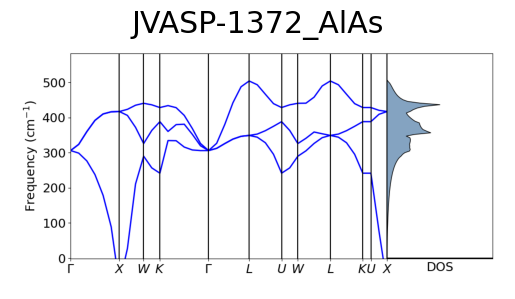

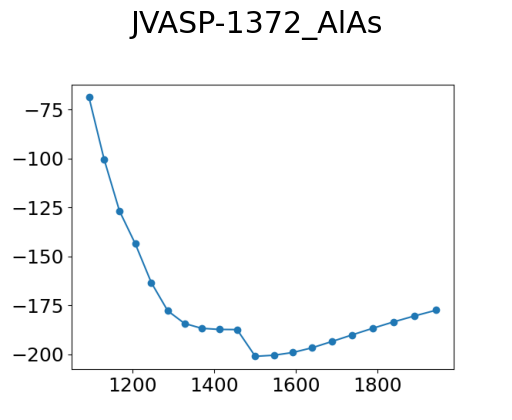

 44%|████▍     | 16/36 [13:40<18:54, 56.73s/it]

Obtaining 3D dataset 76k ...
Reference:https://www.nature.com/articles/s41524-020-00440-1
Other versions:https://doi.org/10.6084/m9.figshare.6815699
Loading the zipfile...
Loading completed.
System
1.0
2.1874686952597293 -1.033047e-10 1.2629352933595248
0.7291565647587371 2.062365242524199 1.2629352933595248
3.991386e-10 2.822336e-10 2.525871585336393
C 
2 
direct
0.875 0.8750000000000001 0.8749999999999998 C
0.12499999999999999 0.125 0.12500000000000003 C



<ipython-input-4-63bca42fdf9c>:4: FutureWarning: Import ExpCellFilter from ase.filters
  ase_atoms = ExpCellFilter(ase_atoms)


      Step     Time          Energy          fmax
FIRE:    0 07:25:46      -15.865852        0.007480
0.837273120880127 System
1.0
2.1874686952597293 -1.033047e-10 1.2629352933595248
0.7291565647587371 2.062365242524199 1.2629352933595248
3.991386e-10 2.822336e-10 2.525871585336393
C 
2 
direct
0.875 0.8750000000000001 0.8749999999999998 C
0.12499999999999999 0.125 0.12500000000000003 C



/usr/local/lib/python3.10/site-packages/spglib/spglib.py:115: DeprecationWarning: dict interface (SpglibDataset['number']) is deprecated.Use attribute interface ({self.__class__.__name__}.{key}) instead
  warnings.warn(
/usr/local/lib/python3.10/site-packages/spglib/spglib.py:115: DeprecationWarning: dict interface (SpglibDataset['international']) is deprecated.Use attribute interface ({self.__class__.__name__}.{key}) instead
  warnings.warn(


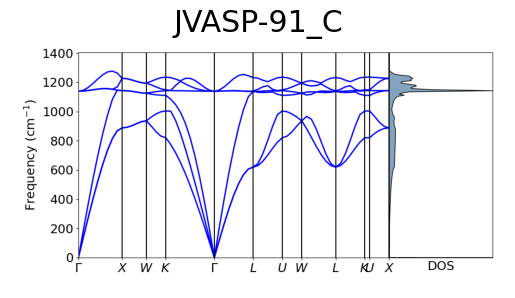

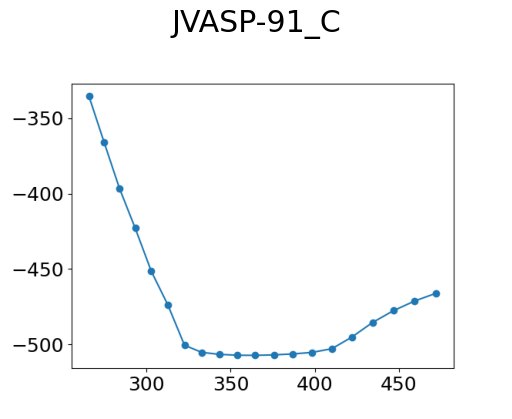

 47%|████▋     | 17/36 [14:56<19:44, 62.35s/it]

Obtaining 3D dataset 76k ...
Reference:https://www.nature.com/articles/s41524-020-00440-1
Other versions:https://doi.org/10.6084/m9.figshare.6815699
Loading the zipfile...
Loading completed.
System
1.0
3.7780018042176415 3.971646e-10 2.1812297047669467
1.2593339351136643 3.5619340280528164 2.1812297047669467
1.1233515e-09 7.943294e-10 4.36246040564249
In As 
1 1 
direct
0.25 0.25 0.25 In
0.0 0.0 0.0 As



<ipython-input-4-63bca42fdf9c>:4: FutureWarning: Import ExpCellFilter from ase.filters
  ase_atoms = ExpCellFilter(ase_atoms)


      Step     Time          Energy          fmax
FIRE:    0 07:27:01       -2.707812        0.014501
0.7905707359313965 System
1.0
3.7780018042176415 3.971646e-10 2.1812297047669467
1.2593339351136643 3.5619340280528164 2.1812297047669467
1.1233515e-09 7.943294e-10 4.36246040564249
In As 
1 1 
direct
0.25 0.25 0.25 In
0.0 0.0 0.0 As



/usr/local/lib/python3.10/site-packages/spglib/spglib.py:115: DeprecationWarning: dict interface (SpglibDataset['number']) is deprecated.Use attribute interface ({self.__class__.__name__}.{key}) instead
  warnings.warn(
/usr/local/lib/python3.10/site-packages/spglib/spglib.py:115: DeprecationWarning: dict interface (SpglibDataset['international']) is deprecated.Use attribute interface ({self.__class__.__name__}.{key}) instead
  warnings.warn(


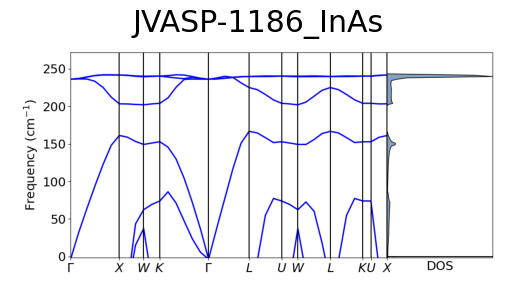

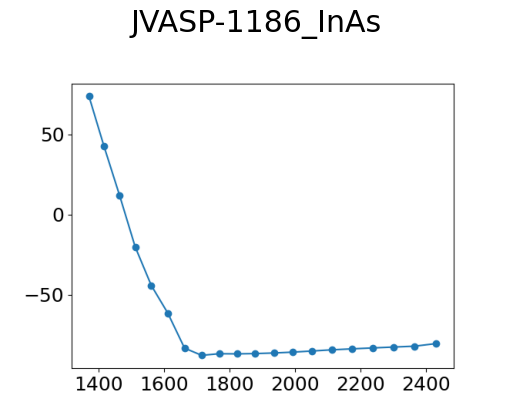

 50%|█████     | 18/36 [15:27<15:52, 52.90s/it]

Obtaining 3D dataset 76k ...
Reference:https://www.nature.com/articles/s41524-020-00440-1
Other versions:https://doi.org/10.6084/m9.figshare.6815699
Loading the zipfile...
Loading completed.
System
1.0
3.812447552586739 0.0 2.201117518505527
1.2708158508622465 3.5944098163596645 2.201117518505527
0.0 0.0 4.402235037011054
Al Sb 
1 1 
direct
0.0 0.0 0.0 Al
0.25000000000000006 0.25 0.24999999999999994 Sb



<ipython-input-4-63bca42fdf9c>:4: FutureWarning: Import ExpCellFilter from ase.filters
  ase_atoms = ExpCellFilter(ase_atoms)


      Step     Time          Energy          fmax
FIRE:    0 07:27:33       -4.951055        0.014500
0.4873178005218506 System
1.0
3.812447552586739 0.0 2.201117518505527
1.2708158508622465 3.5944098163596645 2.201117518505527
0.0 0.0 4.402235037011054
Al Sb 
1 1 
direct
0.0 0.0 0.0 Al
0.25000000000000006 0.25 0.24999999999999994 Sb



/usr/local/lib/python3.10/site-packages/spglib/spglib.py:115: DeprecationWarning: dict interface (SpglibDataset['number']) is deprecated.Use attribute interface ({self.__class__.__name__}.{key}) instead
  warnings.warn(
/usr/local/lib/python3.10/site-packages/spglib/spglib.py:115: DeprecationWarning: dict interface (SpglibDataset['international']) is deprecated.Use attribute interface ({self.__class__.__name__}.{key}) instead
  warnings.warn(


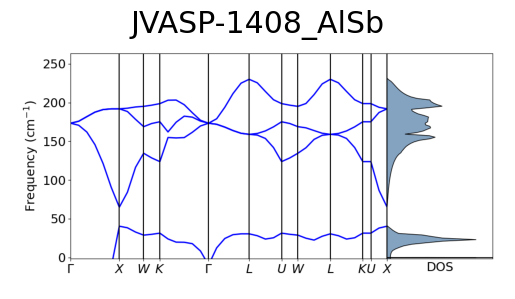

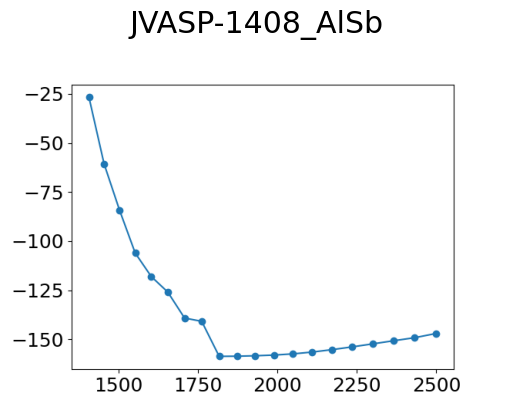

 53%|█████▎    | 19/36 [16:01<13:22, 47.21s/it]

Obtaining 3D dataset 76k ...
Reference:https://www.nature.com/articles/s41524-020-00440-1
Other versions:https://doi.org/10.6084/m9.figshare.6815699
Loading the zipfile...
Loading completed.
System
1.0
3.4247492813810294 -0.0 1.9772799195123152
1.1415830937936766 3.2288845876377086 1.9772799195123152
0.0 0.0 3.9545598390246295
Si Ge 
1 1 
direct
0.0 0.0 0.0 Si
0.24999999999999997 0.25 0.25 Ge



<ipython-input-4-63bca42fdf9c>:4: FutureWarning: Import ExpCellFilter from ase.filters
  ase_atoms = ExpCellFilter(ase_atoms)


      Step     Time          Energy          fmax
FIRE:    0 07:28:05       -5.332785        0.004755
0.5935242176055908 System
1.0
3.4247492813810294 -0.0 1.9772799195123152
1.1415830937936766 3.2288845876377086 1.9772799195123152
0.0 0.0 3.9545598390246295
Si Ge 
1 1 
direct
0.0 0.0 0.0 Si
0.24999999999999997 0.25 0.25 Ge



/usr/local/lib/python3.10/site-packages/spglib/spglib.py:115: DeprecationWarning: dict interface (SpglibDataset['number']) is deprecated.Use attribute interface ({self.__class__.__name__}.{key}) instead
  warnings.warn(
/usr/local/lib/python3.10/site-packages/spglib/spglib.py:115: DeprecationWarning: dict interface (SpglibDataset['international']) is deprecated.Use attribute interface ({self.__class__.__name__}.{key}) instead
  warnings.warn(


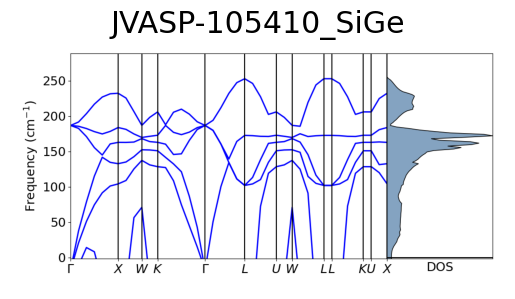

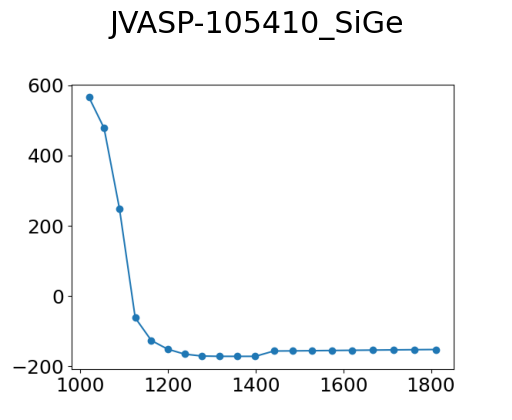

 56%|█████▌    | 20/36 [16:34<11:29, 43.10s/it]

Obtaining 3D dataset 76k ...
Reference:https://www.nature.com/articles/s41524-020-00440-1
Other versions:https://doi.org/10.6084/m9.figshare.6815699
Loading the zipfile...
Loading completed.
System
1.0
3.7936820025137235 0.0 2.1902833745675476
1.2645606675045744 3.5767177657951077 2.1902833745675476
0.0 0.0 4.380566749135095
Ga Sb 
1 1 
direct
0.0 0.0 0.0 Ga
0.25 0.25 0.24999999999999997 Sb



<ipython-input-4-63bca42fdf9c>:4: FutureWarning: Import ExpCellFilter from ase.filters
  ase_atoms = ExpCellFilter(ase_atoms)


      Step     Time          Energy          fmax
FIRE:    0 07:28:40       -1.709641        0.015325
0.5450394153594971 System
1.0
3.7936820025137235 0.0 2.1902833745675476
1.2645606675045744 3.5767177657951077 2.1902833745675476
0.0 0.0 4.380566749135095
Ga Sb 
1 1 
direct
0.0 0.0 0.0 Ga
0.25 0.25 0.24999999999999997 Sb



/usr/local/lib/python3.10/site-packages/spglib/spglib.py:115: DeprecationWarning: dict interface (SpglibDataset['number']) is deprecated.Use attribute interface ({self.__class__.__name__}.{key}) instead
  warnings.warn(
/usr/local/lib/python3.10/site-packages/spglib/spglib.py:115: DeprecationWarning: dict interface (SpglibDataset['international']) is deprecated.Use attribute interface ({self.__class__.__name__}.{key}) instead
  warnings.warn(


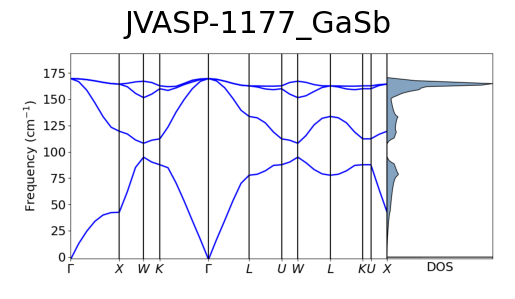

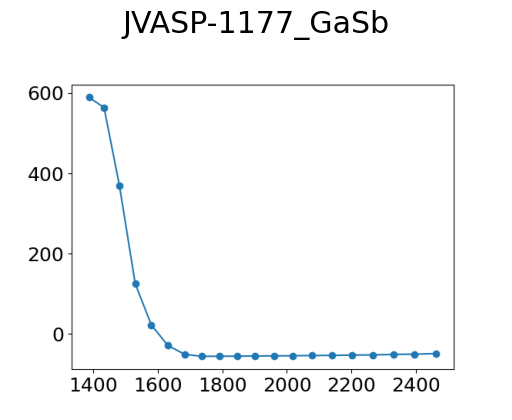

 58%|█████▊    | 21/36 [17:07<10:00, 40.06s/it]

Obtaining 3D dataset 76k ...
Reference:https://www.nature.com/articles/s41524-020-00440-1
Other versions:https://doi.org/10.6084/m9.figshare.6815699
Loading the zipfile...
Loading completed.
System
1.0
-1.277108777115828 -2.212016741513634 0.0
-1.277108777115828 2.212016741513634 0.0
0.0 0.0 -4.2256495453427245
B N 
2 2 
direct
0.3333334206123232 0.6666665793876768 0.49976924795093536 B
0.6666665793876768 0.3333334206123232 0.9997692479509354 B
0.33333286818127345 0.6666671318187268 0.1252307520490646 N
0.6666671318187268 0.33333286818127345 0.6252307520490646 N



<ipython-input-4-63bca42fdf9c>:4: FutureWarning: Import ExpCellFilter from ase.filters
  ase_atoms = ExpCellFilter(ase_atoms)


      Step     Time          Energy          fmax
FIRE:    0 07:29:12      -31.095371        0.191710
FIRE:    1 07:29:13      -31.095673        0.178013
FIRE:    2 07:29:14      -31.096201        0.151348
FIRE:    3 07:29:16      -31.096846        0.112882
FIRE:    4 07:29:18      -31.093725        0.194374
FIRE:    5 07:29:19      -31.094587        0.062905
FIRE:    6 07:29:20      -31.094625        0.107901
FIRE:    7 07:29:21      -31.094650        0.102161
FIRE:    8 07:29:23      -31.094690        0.091106
FIRE:    9 07:29:24      -31.094748        0.075533
FIRE:   10 07:29:25      -31.094801        0.056497
FIRE:   11 07:29:26      -31.094852        0.035232
15.652752876281738 System
1.0
-1.274089368981106 -2.2067869332518915 4.1763836660839415e-10
-1.2740893688756667 2.2067869331910153 3.805591471210086e-09
6.986832117917914e-09 -3.2360294177308702e-09 -4.218239083833711
B N 
2 2 
direct
0.3333339292968445 0.6666665393269755 0.5070544592286533 B
0.6666665317383453 0.33333392608

/usr/local/lib/python3.10/site-packages/spglib/spglib.py:115: DeprecationWarning: dict interface (SpglibDataset['number']) is deprecated.Use attribute interface ({self.__class__.__name__}.{key}) instead
  warnings.warn(
/usr/local/lib/python3.10/site-packages/spglib/spglib.py:115: DeprecationWarning: dict interface (SpglibDataset['international']) is deprecated.Use attribute interface ({self.__class__.__name__}.{key}) instead
  warnings.warn(


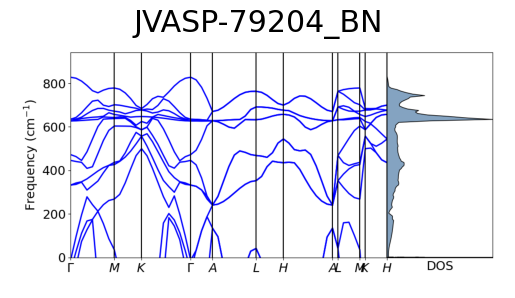

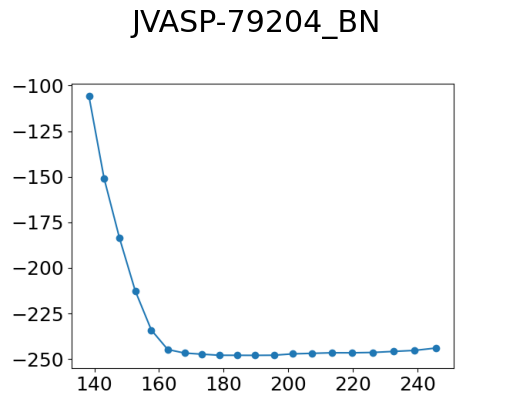

 61%|██████    | 22/36 [18:31<12:24, 53.18s/it]

Obtaining 3D dataset 76k ...
Reference:https://www.nature.com/articles/s41524-020-00440-1
Other versions:https://doi.org/10.6084/m9.figshare.6815699
Loading the zipfile...
Loading completed.
System
1.0
3.3677217590579 2.533606e-10 1.9443546507300569
1.1225739199248372 3.175118118429553 1.9443546507300566
7.166124e-10 5.067214e-10 3.888710298977696
Ga P 
1 1 
direct
0.0 0.0 0.0 Ga
0.24999999999999997 0.25 0.24999999999999997 P



<ipython-input-4-63bca42fdf9c>:4: FutureWarning: Import ExpCellFilter from ase.filters
  ase_atoms = ExpCellFilter(ase_atoms)


      Step     Time          Energy          fmax
FIRE:    0 07:30:36       -3.825331        0.002865
0.5714726448059082 System
1.0
3.3677217590579 2.533606e-10 1.9443546507300569
1.1225739199248372 3.175118118429553 1.9443546507300566
7.166124e-10 5.067214e-10 3.888710298977696
Ga P 
1 1 
direct
0.0 0.0 0.0 Ga
0.24999999999999997 0.25 0.24999999999999997 P



/usr/local/lib/python3.10/site-packages/spglib/spglib.py:115: DeprecationWarning: dict interface (SpglibDataset['number']) is deprecated.Use attribute interface ({self.__class__.__name__}.{key}) instead
  warnings.warn(
/usr/local/lib/python3.10/site-packages/spglib/spglib.py:115: DeprecationWarning: dict interface (SpglibDataset['international']) is deprecated.Use attribute interface ({self.__class__.__name__}.{key}) instead
  warnings.warn(


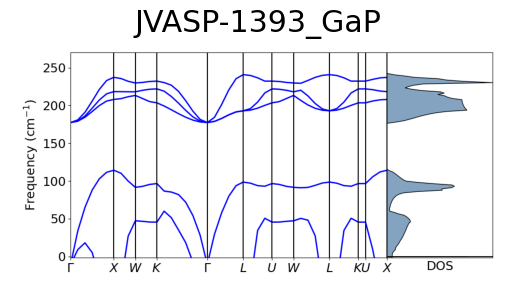

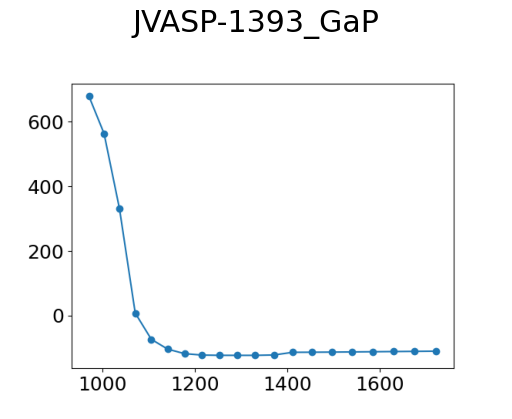

 64%|██████▍   | 23/36 [19:06<10:18, 47.61s/it]

Obtaining 3D dataset 76k ...
Reference:https://www.nature.com/articles/s41524-020-00440-1
Other versions:https://doi.org/10.6084/m9.figshare.6815699
Loading the zipfile...
Loading completed.
System
1.0
2.7886408016740347 -3.149311e-10 1.6100221817296598
0.9295469335944251 2.6291561224262785 1.6100221817296596
-8.907598e-10 -6.298624e-10 3.220045366545002
B P 
1 1 
direct
0.0 0.0 0.0 B
0.25 0.25 0.24999999999999994 P



<ipython-input-4-63bca42fdf9c>:4: FutureWarning: Import ExpCellFilter from ase.filters
  ase_atoms = ExpCellFilter(ase_atoms)


      Step     Time          Energy          fmax
FIRE:    0 07:31:11      -10.254004        0.051906
FIRE:    1 07:31:12      -10.255601        0.050575
FIRE:    2 07:31:13      -10.258634        0.047956
2.179867744445801 System
1.0
2.7843355111890333 -9.901418033751488e-10 1.6075365189611068
0.9281118361995776 2.625097051800609 1.6075365188397233
3.3607826357748994e-09 2.2277678589111144e-09 3.2150740320977564
B P 
1 1 
direct
5.432075685577131e-08 1.5724992265651328e-07 -1.0691318443258775e-07 B
0.24999988120904376 0.2499999294706908 0.24999988867246825 P



/usr/local/lib/python3.10/site-packages/spglib/spglib.py:115: DeprecationWarning: dict interface (SpglibDataset['number']) is deprecated.Use attribute interface ({self.__class__.__name__}.{key}) instead
  warnings.warn(
/usr/local/lib/python3.10/site-packages/spglib/spglib.py:115: DeprecationWarning: dict interface (SpglibDataset['international']) is deprecated.Use attribute interface ({self.__class__.__name__}.{key}) instead
  warnings.warn(


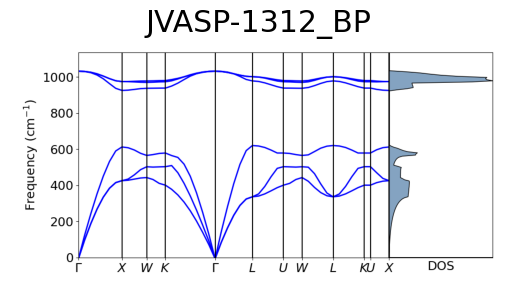

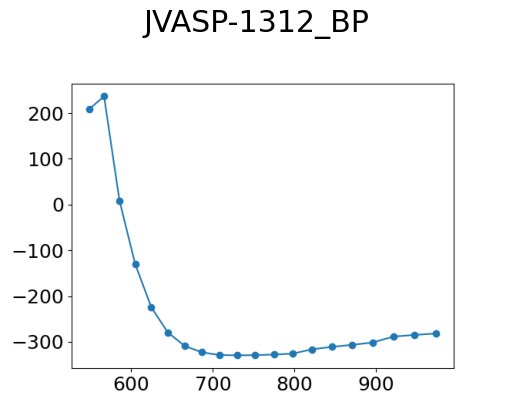

 67%|██████▋   | 24/36 [19:50<09:21, 46.78s/it]

Obtaining 3D dataset 76k ...
Reference:https://www.nature.com/articles/s41524-020-00440-1
Other versions:https://doi.org/10.6084/m9.figshare.6815699
Loading the zipfile...
Loading completed.
System
1.0
3.3768067453542683 1.950831e-10 1.9495999256867476
1.1256025824038562 3.1836839484367916 1.9495999256867473
-7.537433e-10 -5.329769e-10 3.8992008539845386
Al P 
1 1 
direct
0.0 0.0 0.0 Al
0.24999999999999997 0.25 0.25000000000000006 P



<ipython-input-4-63bca42fdf9c>:4: FutureWarning: Import ExpCellFilter from ase.filters
  ase_atoms = ExpCellFilter(ase_atoms)


      Step     Time          Energy          fmax
FIRE:    0 07:31:56       -7.268125        0.002018
0.6784558296203613 System
1.0
3.3768067453542683 1.950831e-10 1.9495999256867476
1.1256025824038562 3.1836839484367916 1.9495999256867473
-7.537433e-10 -5.329769e-10 3.8992008539845386
Al P 
1 1 
direct
0.0 0.0 0.0 Al
0.24999999999999997 0.25 0.25000000000000006 P



/usr/local/lib/python3.10/site-packages/spglib/spglib.py:115: DeprecationWarning: dict interface (SpglibDataset['number']) is deprecated.Use attribute interface ({self.__class__.__name__}.{key}) instead
  warnings.warn(
/usr/local/lib/python3.10/site-packages/spglib/spglib.py:115: DeprecationWarning: dict interface (SpglibDataset['international']) is deprecated.Use attribute interface ({self.__class__.__name__}.{key}) instead
  warnings.warn(


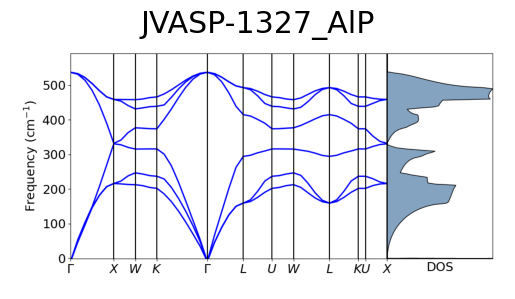

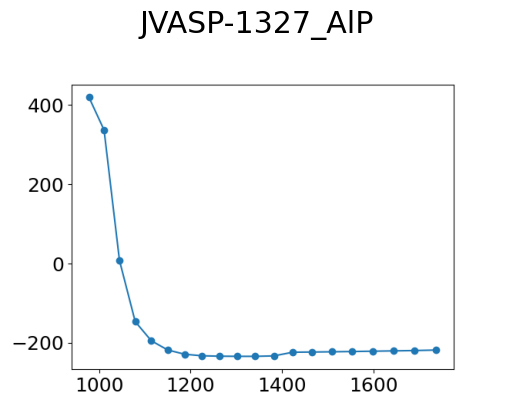

 69%|██████▉   | 25/36 [20:25<07:55, 43.23s/it]

Obtaining 3D dataset 76k ...
Reference:https://www.nature.com/articles/s41524-020-00440-1
Other versions:https://doi.org/10.6084/m9.figshare.6815699
Loading the zipfile...
Loading completed.
System
1.0
3.646780655180086 1.457505e-10 2.1054695860995256
1.2155932186178946 3.4382181775806795 2.1054695860995256
1.50892e-10 1.066968e-10 4.210940171676346
In P 
1 1 
direct
0.0 0.0 0.0 In
0.25 0.25 0.25 P



<ipython-input-4-63bca42fdf9c>:4: FutureWarning: Import ExpCellFilter from ase.filters
  ase_atoms = ExpCellFilter(ase_atoms)


      Step     Time          Energy          fmax
FIRE:    0 07:32:30       -3.719600        0.032038
0.5873105525970459 System
1.0
3.646780655180086 1.457505e-10 2.1054695860995256
1.2155932186178946 3.4382181775806795 2.1054695860995256
1.50892e-10 1.066968e-10 4.210940171676346
In P 
1 1 
direct
0.0 0.0 0.0 In
0.25 0.25 0.25 P



/usr/local/lib/python3.10/site-packages/spglib/spglib.py:115: DeprecationWarning: dict interface (SpglibDataset['number']) is deprecated.Use attribute interface ({self.__class__.__name__}.{key}) instead
  warnings.warn(
/usr/local/lib/python3.10/site-packages/spglib/spglib.py:115: DeprecationWarning: dict interface (SpglibDataset['international']) is deprecated.Use attribute interface ({self.__class__.__name__}.{key}) instead
  warnings.warn(


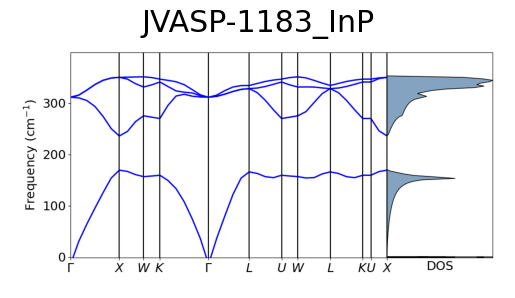

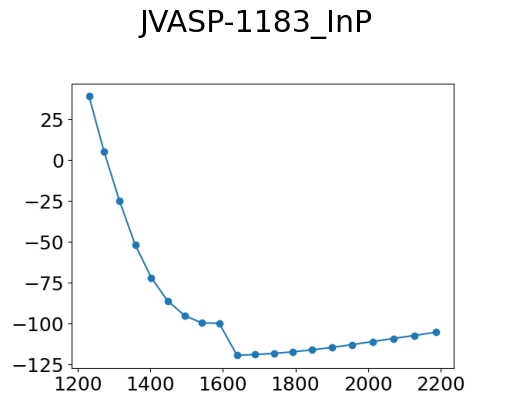

 72%|███████▏  | 26/36 [20:56<06:34, 39.47s/it]

Obtaining 3D dataset 76k ...
Reference:https://www.nature.com/articles/s41524-020-00440-1
Other versions:https://doi.org/10.6084/m9.figshare.6815699
Loading the zipfile...
Loading completed.
System
1.0
3.777046226122458 -2.5576537e-09 2.180678717710524
1.2590157372180613 3.5610332802261557 2.180678717710524
0.0 0.0 4.361357435421048
Cd Se 
1 1 
direct
0.0 0.0 0.0 Cd
0.25000000000000006 0.25 0.25 Se



<ipython-input-4-63bca42fdf9c>:4: FutureWarning: Import ExpCellFilter from ase.filters
  ase_atoms = ExpCellFilter(ase_atoms)


      Step     Time          Energy          fmax
FIRE:    0 07:33:02       -0.290188        0.036207
0.5660362243652344 System
1.0
3.777046226122458 -2.5576537e-09 2.180678717710524
1.2590157372180613 3.5610332802261557 2.180678717710524
0.0 0.0 4.361357435421048
Cd Se 
1 1 
direct
0.0 0.0 0.0 Cd
0.25000000000000006 0.25 0.25 Se



/usr/local/lib/python3.10/site-packages/spglib/spglib.py:115: DeprecationWarning: dict interface (SpglibDataset['number']) is deprecated.Use attribute interface ({self.__class__.__name__}.{key}) instead
  warnings.warn(
/usr/local/lib/python3.10/site-packages/spglib/spglib.py:115: DeprecationWarning: dict interface (SpglibDataset['international']) is deprecated.Use attribute interface ({self.__class__.__name__}.{key}) instead
  warnings.warn(


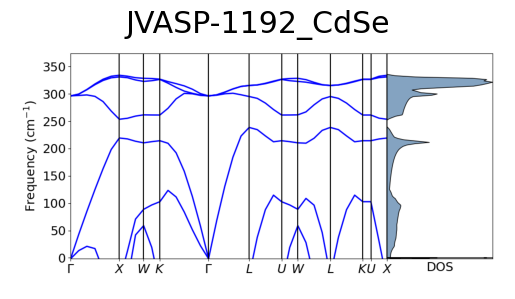

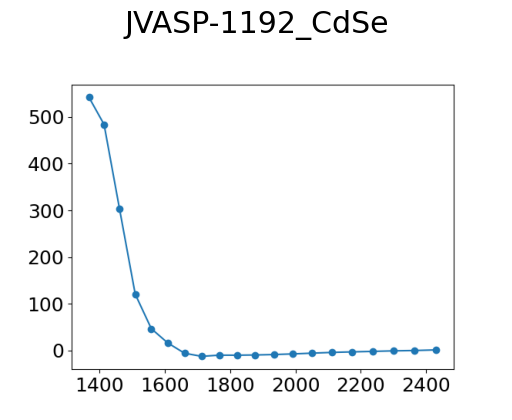

 75%|███████▌  | 27/36 [21:29<05:38, 37.65s/it]

Obtaining 3D dataset 76k ...
Reference:https://www.nature.com/articles/s41524-020-00440-1
Other versions:https://doi.org/10.6084/m9.figshare.6815699
Loading the zipfile...
Loading completed.
System
1.0
3.616656945344388 -2.0744814e-09 2.088077849798458
1.2055526445364497 3.409816748119369 2.088077849798458
0.0 0.0 4.176155699596916
Cd S 
1 1 
direct
0.0 0.0 0.0 Cd
0.25 0.24999999999999997 0.25 S



<ipython-input-4-63bca42fdf9c>:4: FutureWarning: Import ExpCellFilter from ase.filters
  ase_atoms = ExpCellFilter(ase_atoms)


      Step     Time          Energy          fmax
FIRE:    0 07:33:35       -1.433702        0.026538
0.7852206230163574 System
1.0
3.616656945344388 -2.0744814e-09 2.088077849798458
1.2055526445364497 3.409816748119369 2.088077849798458
0.0 0.0 4.176155699596916
Cd S 
1 1 
direct
0.0 0.0 0.0 Cd
0.25 0.24999999999999997 0.25 S



/usr/local/lib/python3.10/site-packages/spglib/spglib.py:115: DeprecationWarning: dict interface (SpglibDataset['number']) is deprecated.Use attribute interface ({self.__class__.__name__}.{key}) instead
  warnings.warn(
/usr/local/lib/python3.10/site-packages/spglib/spglib.py:115: DeprecationWarning: dict interface (SpglibDataset['international']) is deprecated.Use attribute interface ({self.__class__.__name__}.{key}) instead
  warnings.warn(


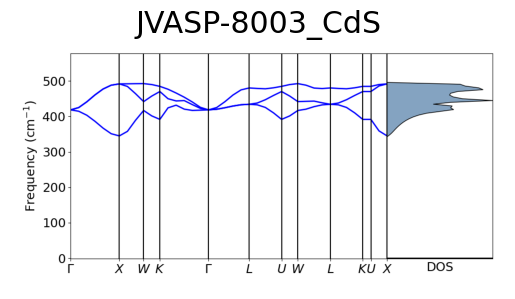

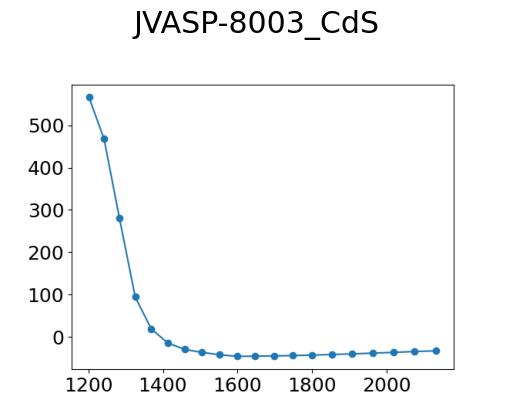

 78%|███████▊  | 28/36 [22:01<04:47, 35.92s/it]

Obtaining 3D dataset 76k ...
Reference:https://www.nature.com/articles/s41524-020-00440-1
Other versions:https://doi.org/10.6084/m9.figshare.6815699
Loading the zipfile...
Loading completed.
System
1.0
3.5008378901472135 6.634685e-10 2.0212097688704245
1.1669456321546012 3.300620830306097 2.0212097688704254
-2.5634453e-09 -1.8126293e-09 4.042418546620883
Zn Se 
1 1 
direct
0.0 0.0 0.0 Zn
0.24999999999999997 0.25 0.25 Se



<ipython-input-4-63bca42fdf9c>:4: FutureWarning: Import ExpCellFilter from ase.filters
  ase_atoms = ExpCellFilter(ase_atoms)


      Step     Time          Energy          fmax
FIRE:    0 07:34:07       -1.140427        0.020444
0.5355930328369141 System
1.0
3.5008378901472135 6.634685e-10 2.0212097688704245
1.1669456321546012 3.300620830306097 2.0212097688704254
-2.5634453e-09 -1.8126293e-09 4.042418546620883
Zn Se 
1 1 
direct
0.0 0.0 0.0 Zn
0.24999999999999997 0.25 0.25 Se



/usr/local/lib/python3.10/site-packages/spglib/spglib.py:115: DeprecationWarning: dict interface (SpglibDataset['number']) is deprecated.Use attribute interface ({self.__class__.__name__}.{key}) instead
  warnings.warn(
/usr/local/lib/python3.10/site-packages/spglib/spglib.py:115: DeprecationWarning: dict interface (SpglibDataset['international']) is deprecated.Use attribute interface ({self.__class__.__name__}.{key}) instead
  warnings.warn(


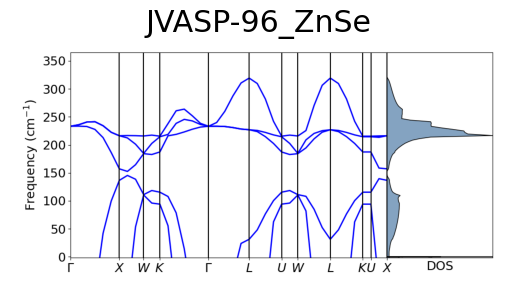

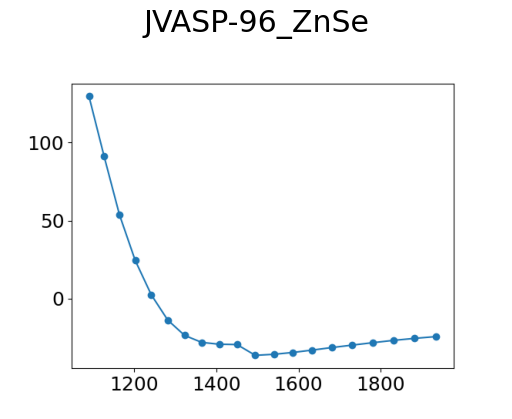

 81%|████████  | 29/36 [22:34<04:05, 35.00s/it]

Obtaining 3D dataset 76k ...
Reference:https://www.nature.com/articles/s41524-020-00440-1
Other versions:https://doi.org/10.6084/m9.figshare.6815699
Loading the zipfile...
Loading completed.
System
1.0
3.774536153388946 1.896638e-09 2.1792292397647874
1.2581783873848023 3.558666821438028 2.1792292397647874
1.9635443e-09 1.3884356e-09 4.358459472727658
Zn Te 
1 1 
direct
0.0 0.0 0.0 Zn
0.24999999999999997 0.25 0.25 Te



<ipython-input-4-63bca42fdf9c>:4: FutureWarning: Import ExpCellFilter from ase.filters
  ase_atoms = ExpCellFilter(ase_atoms)


      Step     Time          Energy          fmax
FIRE:    0 07:34:39       -0.179655        0.018420
0.6614925861358643 System
1.0
3.774536153388946 1.896638e-09 2.1792292397647874
1.2581783873848023 3.558666821438028 2.1792292397647874
1.9635443e-09 1.3884356e-09 4.358459472727658
Zn Te 
1 1 
direct
0.0 0.0 0.0 Zn
0.24999999999999997 0.25 0.25 Te



/usr/local/lib/python3.10/site-packages/spglib/spglib.py:115: DeprecationWarning: dict interface (SpglibDataset['number']) is deprecated.Use attribute interface ({self.__class__.__name__}.{key}) instead
  warnings.warn(
/usr/local/lib/python3.10/site-packages/spglib/spglib.py:115: DeprecationWarning: dict interface (SpglibDataset['international']) is deprecated.Use attribute interface ({self.__class__.__name__}.{key}) instead
  warnings.warn(


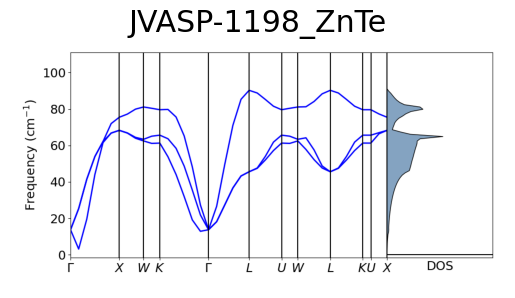

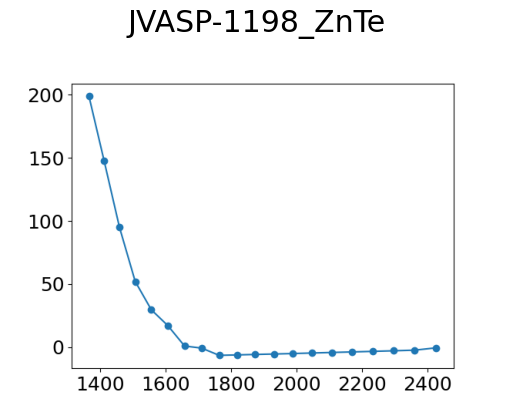

 83%|████████▎ | 30/36 [23:07<03:26, 34.40s/it]

Obtaining 3D dataset 76k ...
Reference:https://www.nature.com/articles/s41524-020-00440-1
Other versions:https://doi.org/10.6084/m9.figshare.6815699
Loading the zipfile...
Loading completed.
System
1.0
1.6347417036915457 -2.8314567805253072 0.0
1.6347417036915457 2.8314567805253072 0.0
0.0 0.0 5.289073367430449
Zn O 
2 2 
direct
0.6666669999999968 0.3333330000000032 0.4989819752523941 Zn
0.3333330000000032 0.6666669999999968 0.9989819752523942 Zn
0.6666669999999968 0.3333330000000032 0.1207080247476044 O
0.3333330000000032 0.6666669999999968 0.6207080247476044 O



<ipython-input-4-63bca42fdf9c>:4: FutureWarning: Import ExpCellFilter from ase.filters
  ase_atoms = ExpCellFilter(ase_atoms)


      Step     Time          Energy          fmax
FIRE:    0 07:35:12       -8.231026        0.116392
FIRE:    1 07:35:13       -8.231590        0.110790
FIRE:    2 07:35:14       -8.232697        0.099696
FIRE:    3 07:35:15       -8.234291        0.083358
FIRE:    4 07:35:15       -8.236325        0.062232
FIRE:    5 07:35:16       -8.238729        0.037068
4.9852306842803955 System
1.0
1.6273719967740992 -2.8186919561678785 -2.7751638810455966e-10
1.627371995295616 2.8186919553142755 7.435709672342253e-10
7.539407775177287e-10 9.536797407764794e-10 5.268878672803307
Zn O 
2 2 
direct
0.6666669884380592 0.33333319448382176 0.49605016614156316 Zn
0.3333331978136762 0.6666669870751503 0.9960499361424406 Zn
0.6666670845938195 0.33333309237248104 0.12363914923655872 O
0.3333330972128382 0.6666670946748986 0.6236387588981397 O



/usr/local/lib/python3.10/site-packages/spglib/spglib.py:115: DeprecationWarning: dict interface (SpglibDataset['number']) is deprecated.Use attribute interface ({self.__class__.__name__}.{key}) instead
  warnings.warn(
/usr/local/lib/python3.10/site-packages/spglib/spglib.py:115: DeprecationWarning: dict interface (SpglibDataset['international']) is deprecated.Use attribute interface ({self.__class__.__name__}.{key}) instead
  warnings.warn(


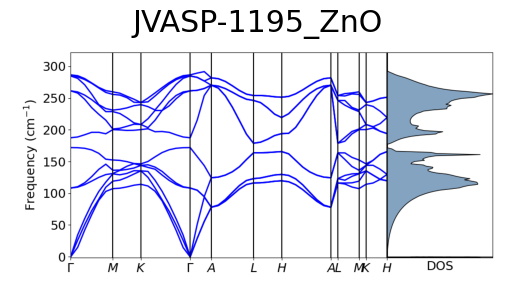

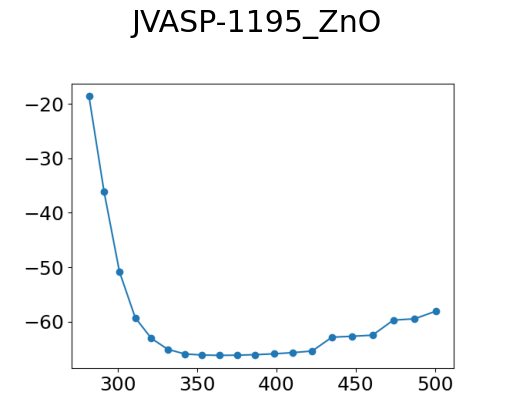

 86%|████████▌ | 31/36 [24:05<03:26, 41.39s/it]

Obtaining 3D dataset 76k ...
Reference:https://www.nature.com/articles/s41524-020-00440-1
Other versions:https://doi.org/10.6084/m9.figshare.6815699
Loading the zipfile...
Loading completed.
System
1.0
0.0 5.117400519910129 -0.0129583688619494
5.192762305644317 0.0 0.0
0.0 -0.8774675169852882 -5.222730063842967
Hf O 
4 8 
direct
0.7235004611807277 0.541668514756685 0.2919361045049176 Hf
0.27649953881927214 0.0416685147566851 0.2080638954950825 Hf
0.2764995388192722 0.458331485243315 0.7080638954950891 Hf
0.7235004611807277 0.9583314852433151 0.7919361045049109 Hf
0.5530064344320458 0.2580595187702125 0.0204363299877572 O
0.4469935655679546 0.7580595187702126 0.4795636700122431 O
0.44699356556795466 0.7419404812297875 0.979563670012243 O
0.5530064344320458 0.2419404812297875 0.520436329987757 O
0.9286719767960276 0.6638587974986725 0.6583338289137491 O
0.07132802320397172 0.16385879749867252 0.8416661710862509 O
0.0713280232039717 0.3361412025013276 0.3416661710862509 O
0.92867197679602

<ipython-input-4-63bca42fdf9c>:4: FutureWarning: Import ExpCellFilter from ase.filters
  ase_atoms = ExpCellFilter(ase_atoms)


      Step     Time          Energy          fmax
FIRE:    0 07:36:12      -98.451942        0.305046
FIRE:    1 07:36:13      -98.473114        0.293053
FIRE:    2 07:36:14      -98.494675        0.235486
FIRE:    3 07:36:15      -98.397034        0.193670
FIRE:    4 07:36:16      -98.883591        0.190247
FIRE:    5 07:36:18      -98.957794        0.250657
FIRE:    6 07:36:20      -99.024490        0.334694
FIRE:    7 07:36:21      -98.917282        0.457156
FIRE:    8 07:36:22      -98.754868        0.756537
FIRE:    9 07:36:24      -98.395271        1.093886
FIRE:   10 07:36:25      -98.376953        1.204781
FIRE:   11 07:36:26      -98.431389        0.730027
FIRE:   12 07:36:28      -98.690712        0.293229
FIRE:   13 07:36:29      -98.725594        0.300743
FIRE:   14 07:36:31      -98.782883        0.374389
FIRE:   15 07:36:33      -98.783020        0.372503
FIRE:   16 07:36:34      -98.783295        0.368739
FIRE:   17 07:36:36      -98.783707        0.363127
FIRE:   18 07:

/usr/local/lib/python3.10/site-packages/spglib/spglib.py:115: DeprecationWarning: dict interface (SpglibDataset['number']) is deprecated.Use attribute interface ({self.__class__.__name__}.{key}) instead
  warnings.warn(
/usr/local/lib/python3.10/site-packages/spglib/spglib.py:115: DeprecationWarning: dict interface (SpglibDataset['international']) is deprecated.Use attribute interface ({self.__class__.__name__}.{key}) instead
  warnings.warn(


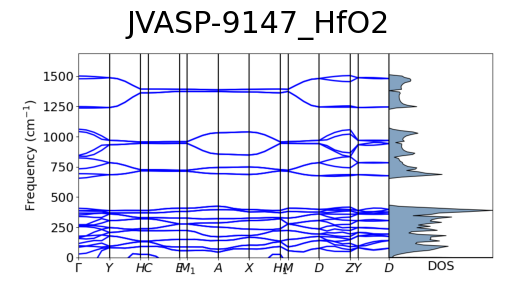

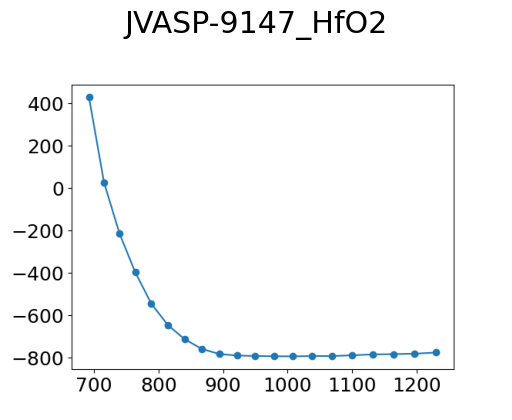

 89%|████████▉ | 32/36 [27:52<06:27, 96.96s/it]

Obtaining 3D dataset 76k ...
Reference:https://www.nature.com/articles/s41524-020-00440-1
Other versions:https://doi.org/10.6084/m9.figshare.6815699
Loading the zipfile...
Loading completed.
System
1.0
2.468627988365564 -4.2757896087940415 0.0
2.468627988365564 4.2757896087940415 0.0
0.0 0.0 5.44931282480302
Si O 
3 6 
direct
0.5344909109814234 -1.293453547059911e-11 0.6666669999999968 Si
-1.293453547059911e-11 0.5344909109814234 0.3333330000000032 Si
0.46550908903151156 0.46550908903151156 0.0 Si
0.27447715163336683 0.8625903927696519 0.44719748368592643 O
0.5881132411439812 0.7255228483312873 0.7805304836859231 O
0.13740960722265158 0.41188675889906023 0.11386448368592358 O
0.41188675889906023 0.1374096072226516 0.8861355163140763 O
0.7255228483312873 0.5881132411439812 0.2194695163140772 O
0.8625903927696519 0.27447715163336683 0.552802516314073 O



<ipython-input-4-63bca42fdf9c>:4: FutureWarning: Import ExpCellFilter from ase.filters
  ase_atoms = ExpCellFilter(ase_atoms)


      Step     Time          Energy          fmax
FIRE:    0 07:39:56      -56.743919        0.096459
FIRE:    1 07:39:58      -56.744007        0.095788
FIRE:    2 07:39:59      -56.744171        0.094455
FIRE:    3 07:40:00      -56.483356        0.105096
FIRE:    4 07:40:01      -56.483677        0.101770
FIRE:    5 07:40:02      -56.484066        0.097526
FIRE:    6 07:40:03      -56.484520        0.092370
FIRE:    7 07:40:04      -56.485016        0.086320
FIRE:    8 07:40:04      -56.485611        0.078661
FIRE:    9 07:40:05      -56.486279        0.069198
FIRE:   10 07:40:06      -56.487022        0.057786
FIRE:   11 07:40:07      -56.487785        0.044175
11.67655324935913 System
1.0
2.4708368123513083 -4.279615454526099 6.524567869703337e-11
2.470836791099223 4.279615442256202 1.5059241668532222e-08
1.6693090910873726e-08 9.554606530967604e-09 5.463177413233249
Si O 
3 6 
direct
0.549713031499131 2.1438035660519277e-07 0.6666662064499539 Si
4.0168120694865897e-07 0.549713072

/usr/local/lib/python3.10/site-packages/spglib/spglib.py:115: DeprecationWarning: dict interface (SpglibDataset['number']) is deprecated.Use attribute interface ({self.__class__.__name__}.{key}) instead
  warnings.warn(
/usr/local/lib/python3.10/site-packages/spglib/spglib.py:115: DeprecationWarning: dict interface (SpglibDataset['international']) is deprecated.Use attribute interface ({self.__class__.__name__}.{key}) instead
  warnings.warn(


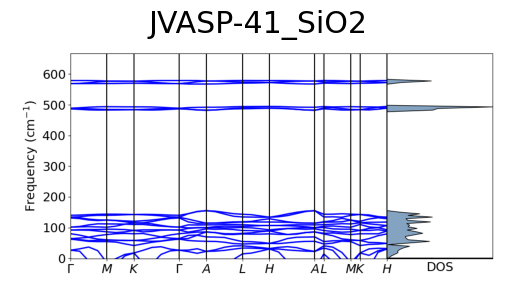

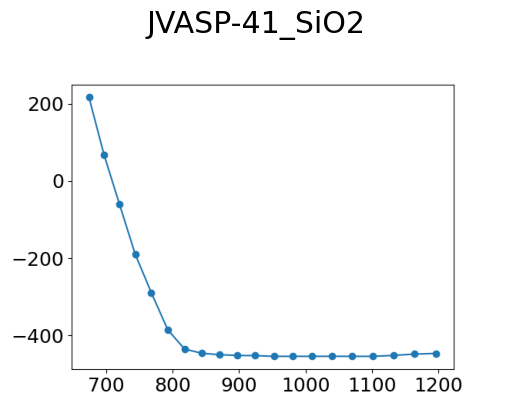

 92%|█████████▏| 33/36 [29:56<05:15, 105.24s/it]

Obtaining 3D dataset 76k ...
Reference:https://www.nature.com/articles/s41524-020-00440-1
Other versions:https://doi.org/10.6084/m9.figshare.6815699
Loading the zipfile...
Loading completed.
System
1.0
4.776526794928306 0.0 0.0
0.0 5.838264270867111 -0.7097734216650913
0.0 0.108274823964545 5.880253405370251
Si O 
4 8 
direct
0.3627133925261981 0.034367237716682 0.3488769544248475 Si
0.862713392526198 0.9656327622833178 0.6511230455751525 Si
0.1372866074738017 0.6511230455754428 0.9656327622841409 Si
0.6372866074738023 0.34887695442455696 0.03436723771585899 Si
0.3985751331282085 0.47944274269305726 0.8967240560436891 O
0.6014248668717913 0.8967240560437921 0.4794427426936858 O
0.0 0.7338675325353288 0.7338675325363836 O
0.8985751331282087 0.5205572573069426 0.10327594395631098 O
0.1014248668717913 0.10327594395620798 0.520557257306314 O
0.25 0.872745606896388 0.1272543931064297 O
0.5 0.2661324674646713 0.2661324674636159 O
0.75 0.1272543931036119 0.872745606893571 O



<ipython-input-4-63bca42fdf9c>:4: FutureWarning: Import ExpCellFilter from ase.filters
  ase_atoms = ExpCellFilter(ase_atoms)


      Step     Time          Energy          fmax
FIRE:    0 07:42:00      -75.343628        0.047099
1.367382526397705 System
1.0
4.776526794928306 0.0 0.0
0.0 5.838264270867111 -0.7097734216650913
0.0 0.108274823964545 5.880253405370251
Si O 
4 8 
direct
0.3627133925261981 0.034367237716682 0.3488769544248475 Si
0.862713392526198 0.9656327622833178 0.6511230455751525 Si
0.1372866074738017 0.6511230455754428 0.9656327622841409 Si
0.6372866074738023 0.34887695442455696 0.03436723771585899 Si
0.3985751331282085 0.47944274269305726 0.8967240560436891 O
0.6014248668717913 0.8967240560437921 0.4794427426936858 O
0.0 0.7338675325353288 0.7338675325363836 O
0.8985751331282087 0.5205572573069426 0.10327594395631098 O
0.1014248668717913 0.10327594395620798 0.520557257306314 O
0.25 0.872745606896388 0.1272543931064297 O
0.5 0.2661324674646713 0.2661324674636159 O
0.75 0.1272543931036119 0.872745606893571 O



/usr/local/lib/python3.10/site-packages/spglib/spglib.py:115: DeprecationWarning: dict interface (SpglibDataset['number']) is deprecated.Use attribute interface ({self.__class__.__name__}.{key}) instead
  warnings.warn(
/usr/local/lib/python3.10/site-packages/spglib/spglib.py:115: DeprecationWarning: dict interface (SpglibDataset['international']) is deprecated.Use attribute interface ({self.__class__.__name__}.{key}) instead
  warnings.warn(


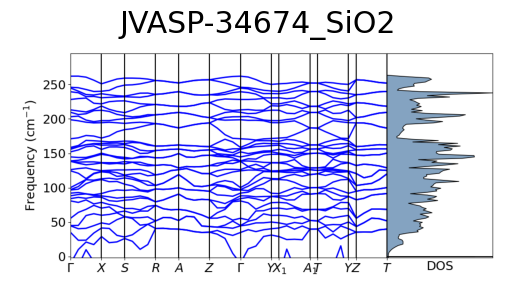

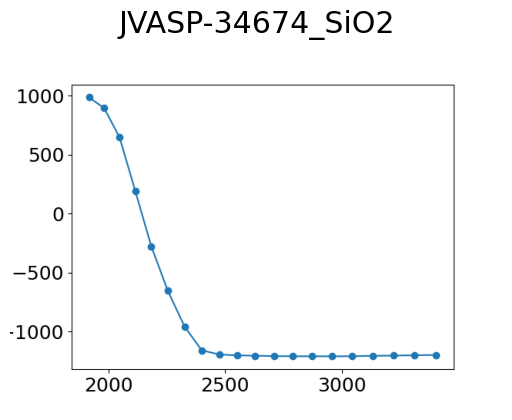

 94%|█████████▍| 34/36 [32:38<04:04, 122.31s/it]

Obtaining 3D dataset 76k ...
Reference:https://www.nature.com/articles/s41524-020-00440-1
Other versions:https://doi.org/10.6084/m9.figshare.6815699
Loading the zipfile...
Loading completed.
System
1.0
0.0 5.173242160810821 -0.0355908636674531
5.26057114023353 0.0 0.0
0.0 -0.8987737989887791 -5.267201824954918
Zr O 
4 8 
direct
0.2766662745005197 0.0417124805416941 0.20965729935898092 Zr
0.2766662745005197 0.458287519458306 0.7096572993589809 Zr
0.7233337254994803 0.5417124805416949 0.290342700641019 Zr
0.7233337254994802 0.9582875194583051 0.7903427006410192 Zr
0.9284098774918016 0.8381306746433572 0.1602917012332585 O
0.9284098774918017 0.6618693253566428 0.6602917012332581 O
0.44820896607536537 0.7420757326016326 0.979692963707992 O
0.5517910339246351 0.24207573260163254 0.520307036292008 O
0.44820896607536537 0.7579242673983674 0.47969296370799236 O
0.5517910339246351 0.2579242673983673 0.0203070362920076 O
0.0715901225081983 0.3381306746433573 0.3397082987667415 O
0.07159012250819

<ipython-input-4-63bca42fdf9c>:4: FutureWarning: Import ExpCellFilter from ase.filters
  ase_atoms = ExpCellFilter(ase_atoms)


      Step     Time          Energy          fmax
FIRE:    0 07:44:43      -90.629936        0.437131
FIRE:    1 07:44:45      -90.631493        0.424447
FIRE:    2 07:44:47      -90.634399        0.399579
FIRE:    3 07:44:48      -90.638374        0.363479
FIRE:    4 07:44:49      -90.643013        0.317499
FIRE:    5 07:44:50      -90.647820        0.263500
FIRE:    6 07:44:51      -90.394196        0.289716
FIRE:    7 07:44:52      -90.399300        0.225050
FIRE:    8 07:44:53      -90.404175        0.160326
FIRE:    9 07:44:54      -90.846619        0.200730
FIRE:   10 07:44:55      -90.848885        0.191474
FIRE:   11 07:44:56      -90.849167        0.189179
FIRE:   12 07:44:58      -90.849747        0.184630
FIRE:   13 07:44:59      -90.850517        0.177896
FIRE:   14 07:45:01      -90.851501        0.169095
FIRE:   15 07:45:02      -90.852592        0.158385
FIRE:   16 07:45:03      -90.853745        0.145996
FIRE:   17 07:45:04      -90.854912        0.132251
FIRE:   18 07:

/usr/local/lib/python3.10/site-packages/spglib/spglib.py:115: DeprecationWarning: dict interface (SpglibDataset['number']) is deprecated.Use attribute interface ({self.__class__.__name__}.{key}) instead
  warnings.warn(
/usr/local/lib/python3.10/site-packages/spglib/spglib.py:115: DeprecationWarning: dict interface (SpglibDataset['international']) is deprecated.Use attribute interface ({self.__class__.__name__}.{key}) instead
  warnings.warn(


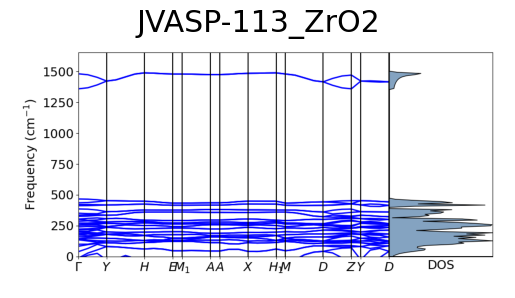

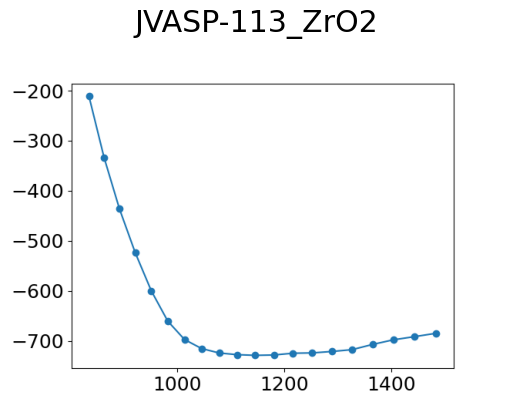

 97%|█████████▋| 35/36 [38:25<03:09, 189.69s/it]

Obtaining 3D dataset 76k ...
Reference:https://www.nature.com/articles/s41524-020-00440-1
Other versions:https://doi.org/10.6084/m9.figshare.6815699
Loading the zipfile...
Loading completed.
System
1.0
4.253255599774612 -0.0011343765684713 2.94300731057024
1.541858721105255 3.963944319736534 2.943006924432697
-0.0016591490976551 -0.0011346142113319 5.172181923360239
Al O 
4 6 
direct
0.6477364362962323 0.647736309763748 0.6477360114118497 Al
0.8522638418686822 0.8522638526309696 0.85226370832237 Al
0.1477363897136121 0.14773635607044286 0.14773596668440347 Al
0.3522637530507079 0.35226386642922947 0.35226355098570783 Al
0.4439293508818836 0.056070876783490195 0.7499998963996108 O
0.943929362850431 0.2500001063057983 0.5560706222914198 O
0.05607079731413906 0.7500001080435489 0.4439289539634804 O
0.7500001291782308 0.4439294294515994 0.05607059219981743 O
0.25000008282022634 0.5560707875779605 0.9439290055331974 O
0.5560708560258524 0.94392930694321 0.24999969220814755 O



<ipython-input-4-63bca42fdf9c>:4: FutureWarning: Import ExpCellFilter from ase.filters
  ase_atoms = ExpCellFilter(ase_atoms)


      Step     Time          Energy          fmax
FIRE:    0 07:50:31      -59.749622        0.089421
FIRE:    1 07:50:33      -59.749752        0.088289
FIRE:    2 07:50:34      -59.749985        0.086005
FIRE:    3 07:50:36      -59.750332        0.082523
FIRE:    4 07:50:38      -59.902100        0.101719
FIRE:    5 07:50:39      -59.902653        0.096166
FIRE:    6 07:50:40      -59.903240        0.088329
FIRE:    7 07:50:42      -59.903851        0.078093
FIRE:    8 07:50:43      -59.904495        0.063877
FIRE:    9 07:50:44      -59.905087        0.044645
14.095136642456055 System
1.0
4.257927958480946 -0.0026694906169046086 2.9435122922424286
1.5421231082620828 3.9688554025652567 2.94351193161419
-0.0039041028330336386 -0.00266972308265683 5.17631119185035
Al O 
4 6 
direct
0.6507287876150478 0.6507286463817292 0.6507291294167771 Al
0.849271980484714 0.8492715952708185 0.8492729410503542 Al
0.15072852827306737 0.15072879175131237 0.1507281933024459 Al
0.34927181013756287 0.349

/usr/local/lib/python3.10/site-packages/spglib/spglib.py:115: DeprecationWarning: dict interface (SpglibDataset['number']) is deprecated.Use attribute interface ({self.__class__.__name__}.{key}) instead
  warnings.warn(
/usr/local/lib/python3.10/site-packages/spglib/spglib.py:115: DeprecationWarning: dict interface (SpglibDataset['international']) is deprecated.Use attribute interface ({self.__class__.__name__}.{key}) instead
  warnings.warn(


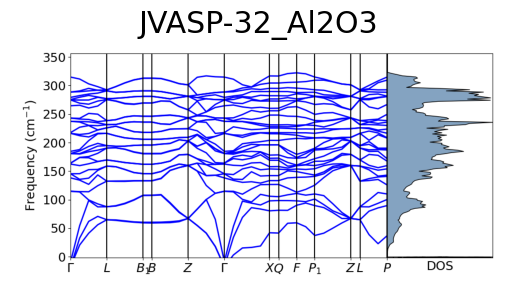

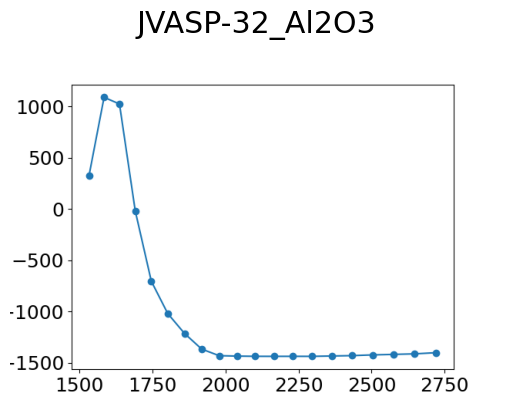

100%|██████████| 36/36 [42:29<00:00, 70.83s/it] 

CPU times: user 38min 8s, sys: 10min 24s, total: 48min 32s
Wall time: 42min 29s


In [7]:
%%time
%matplotlib inline
# Note this is a different model than that published in originall
# https://doi.org/10.1039/D2DD00096B
import matplotlib.pyplot as plt
#jids=['JVASP-1002']
jids=jids_check
model_path = default_path()

calc = AlignnAtomwiseCalculator(
    path=model_path,
    stress_wt=0.05,
)
aff_lat = []
wiki_lat = []
formulas = []
for jid in tqdm(jids, total=len(jids)):
    s = Atoms.from_dict(get_jid_data(jid=jid, dataset="dft_3d")["atoms"])

    print(s)
    t1 = time.time()
    formula=s.composition.reduced_formula
    opt = general_relaxer(atoms=s, calculator=calc)
    t2 = time.time()
    aff_lat.append(opt.lattice_mat[0][0])
    formulas.append(s.composition.reduced_formula)
    print(t2 - t1, opt)  # , w cs, mean_absolute_error(iki_lat, aff_lat))
    strains = np.arange(-0.1, 0.1, 0.01)
    vols = []
    ens = []
    for i in (strains):
        sup = opt.get_conventional_atoms.make_supercell_matrix([2, 2, 2])
        atms = sup.strain_atoms(i)
        # atms=opt.strain_atoms(i)
        ase_atoms = atms.ase_converter()
        ase_atoms.calc = calc
        en = ase_atoms.get_potential_energy()
        ens.append(en)
        vols.append(atms.volume)
        # vols.append(atms.volume**(1/3))
    plt.plot(vols, ens, "-o")
    fname = "ev_" + jid +"_"+formula+ ".png"
    plt.savefig(fname)
    plt.close()
    atoms = opt.get_primitive_atoms
    name = jid +"_"+formula
    phonopy_bands_figname = "ph_" + name+ ".png"

    phonopy_bands_figname = "ph_" + jid +"_"+formula+ ".png"
    ph = phonons(
        model_path=model_path,
        atoms=atoms,
        phonopy_bands_figname=phonopy_bands_figname,
        force_multiplier=1.9,
    )
    plt.figure()
    plt.axis('off')
    plt.title(name)
    plt.imshow(plt.imread(phonopy_bands_figname))
    plt.show()
    plt.close()

    plt.figure()
    plt.axis('off')
    plt.title(name)
    plt.imshow(plt.imread(fname))
    plt.show()
    plt.close()

In [9]:
!pip install -q git+https://github.com/usnistgov/intermat.git@develop

  Preparing metadata (setup.py) ... done


dir_path /usr/local/lib/python3.10/site-packages/alignn/ff/v12.2.2024_dft_3d_307k
model_path /usr/local/lib/python3.10/site-packages/alignn/ff/v12.2.2024_dft_3d_307k


/usr/local/lib/python3.10/site-packages/spglib/spglib.py:115: DeprecationWarning: dict interface (SpglibDataset['number']) is deprecated.Use attribute interface ({self.__class__.__name__}.{key}) instead
  warnings.warn(
/usr/local/lib/python3.10/site-packages/spglib/spglib.py:115: DeprecationWarning: dict interface (SpglibDataset['international']) is deprecated.Use attribute interface ({self.__class__.__name__}.{key}) instead
  warnings.warn(


len generated 40


100%|██████████| 40/40 [00:25<00:00,  1.58it/s]


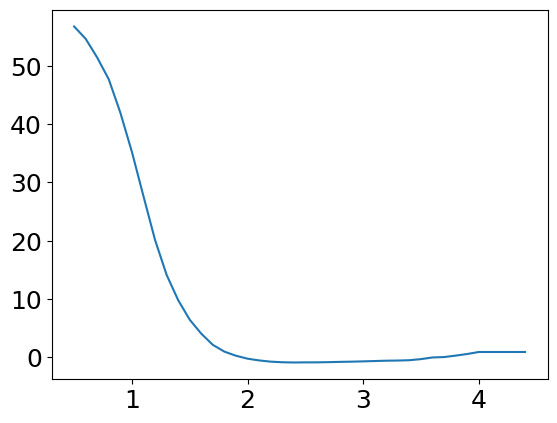

Min val -0.9049236540363553 at 2.3999999999999995


In [16]:
from jarvis.db.jsonutils import loadjson
from jarvis.core.atoms import Atoms
from jarvis.io.vasp.inputs import Poscar
from intermat.generate import InterfaceCombi
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
poscar_1="""SePb
1.0
3.7915451495815202 2.0179111e-09 2.189049588909996
1.2638480536514642 3.5747026449991512 2.189049588909996
0.0 0.0 4.378099177819992
Pb Se
1 1
Cartesian
0.0 0.0 0.0
2.5277 1.78735 4.3781
"""
poscar_2="""Pb
1.0
3.0698776614655223 1.6064780811e-06 1.7723974364942805
1.0232937672951337 2.894307780811061 1.7723973872638596
2.09483931e-06 1.4211877594e-06 3.544790250482119
Pb
1
Cartesian
-7.37161948995e-10 1.114499506167e-09 7.940777072720001e-10
"""
atoms1 = Poscar.from_string(poscar_1).atoms
atoms2 = Poscar.from_string(poscar_2).atoms
seperations=np.arange(0.5,4.5,0.1)
# disp_intvl = 0.1 for xy-plane scan
x = InterfaceCombi(
    film_indices=[[1, 0, 0]],
    subs_indices=[[1, 0, 0]],
    vacuum_interface=2,
    film_mats=[atoms1],
    subs_mats=[atoms2],
    disp_intvl=0.0,
    seperations=seperations,
    from_conventional_structure_film=True,
    from_conventional_structure_subs=True,
    max_area=300,
    ltol=0.08,
    dataset=[None],

)
extra_params={}
extra_params["alignn_params"]={}
extra_params["alignn_params"]["model_path"]=default_path()

structs = x.generate()
wads = x.calculate_wad(method='alignn_ff',extra_params=extra_params)
plt.plot(seperations,wads)
plt.show()
print('Min val',min(wads),'at',seperations[np.argmin(wads)])

In [18]:
from jarvis.db.jsonutils import loadjson
from jarvis.core.atoms import Atoms
from jarvis.io.vasp.inputs import Poscar
from intermat.generate import InterfaceCombi
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
poscar_1="""SePb
1.0
3.7915451495815202 2.0179111e-09 2.189049588909996
1.2638480536514642 3.5747026449991512 2.189049588909996
0.0 0.0 4.378099177819992
Pb Se
1 1
Cartesian
0.0 0.0 0.0
2.5277 1.78735 4.3781
"""
poscar_2="""Pb
1.0
3.0698776614655223 1.6064780811e-06 1.7723974364942805
1.0232937672951337 2.894307780811061 1.7723973872638596
2.09483931e-06 1.4211877594e-06 3.544790250482119
Pb
1
Cartesian
-7.37161948995e-10 1.114499506167e-09 7.940777072720001e-10
"""
atoms1 = Poscar.from_string(poscar_1).atoms
atoms2 = Poscar.from_string(poscar_2).atoms

# disp_intvl = 0.1 for xy-plane scan
x = InterfaceCombi(
    film_indices=[[1, 0, 0]],
    subs_indices=[[1, 0, 0]],
    vacuum_interface=2,
    film_mats=[atoms1],
    subs_mats=[atoms2],
    disp_intvl=0.1,
    seperations=[seperations[np.argmin(wads)]],
    from_conventional_structure_film=True,
    from_conventional_structure_subs=True,
    max_area=300,
    ltol=0.08,
    dataset=[None],

)
extra_params={}
extra_params["alignn_params"]={}
extra_params["alignn_params"]["model_path"]=default_path()

structs = x.generate()
wads = x.calculate_wad(method='alignn_ff',extra_params=extra_params)


dir_path /usr/local/lib/python3.10/site-packages/alignn/ff/v12.2.2024_dft_3d_307k
model_path /usr/local/lib/python3.10/site-packages/alignn/ff/v12.2.2024_dft_3d_307k


/usr/local/lib/python3.10/site-packages/spglib/spglib.py:115: DeprecationWarning: dict interface (SpglibDataset['number']) is deprecated.Use attribute interface ({self.__class__.__name__}.{key}) instead
  warnings.warn(
/usr/local/lib/python3.10/site-packages/spglib/spglib.py:115: DeprecationWarning: dict interface (SpglibDataset['international']) is deprecated.Use attribute interface ({self.__class__.__name__}.{key}) instead
  warnings.warn(


len generated 121


100%|██████████| 121/121 [01:22<00:00,  1.46it/s]


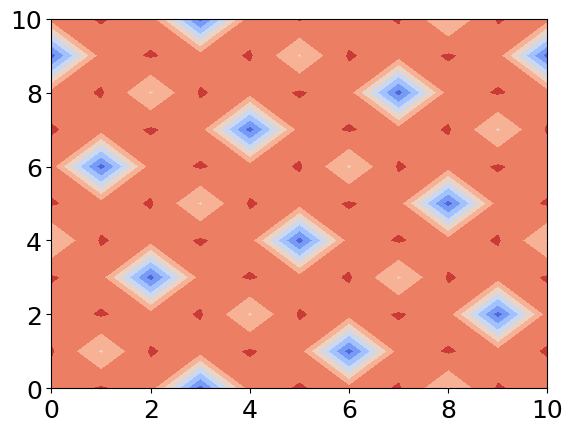

In [28]:
from matplotlib import cm

X = x.X
Y = x.Y

wads = np.array(wads).reshape(len(X), len(Y))
plt.contourf(wads, cmap=cm.coolwarm)
